データを読み込んでいます...
 - smart_home_0101.csv: 読み込み完了 (1786 行)
 - smart_home_1229-1.csv: 読み込み完了 (3389 行)
 - smart_home_1231.csv: 読み込み完了 (3095 行)
使用する特徴量の数: 81

 Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張中...
[Living] 学習データ数: 23156
[Living] モデル学習中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data.ffill(inplace=True)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to


★ Living 正解率 (Accuracy): 0.9770
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1676
           1       0.97      0.98      0.97       310
           2       0.95      0.96      0.95       495

    accuracy                           0.98      2481
   macro avg       0.97      0.97      0.97      2481
weighted avg       0.98      0.98      0.98      2481



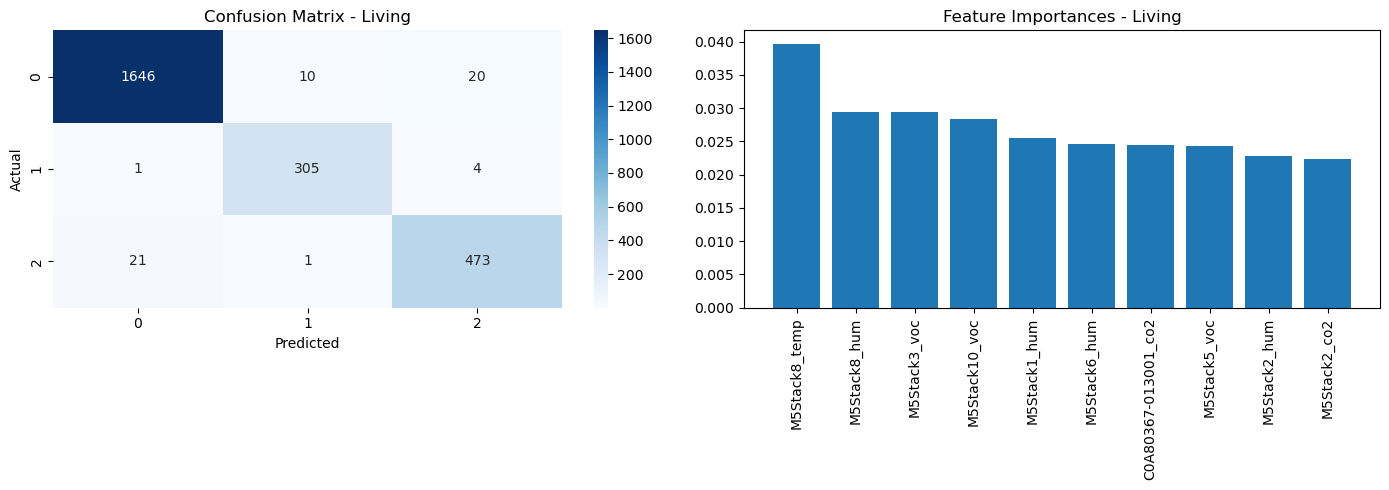


 Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張中...
[Japanese (Washitu)] 学習データ数: 23156
[Japanese (Washitu)] モデル学習中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[


★ Japanese (Washitu) 正解率 (Accuracy): 0.9871
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2000
           1       0.95      0.99      0.97       186
           2       0.97      0.95      0.96       295

    accuracy                           0.99      2481
   macro avg       0.97      0.98      0.97      2481
weighted avg       0.99      0.99      0.99      2481



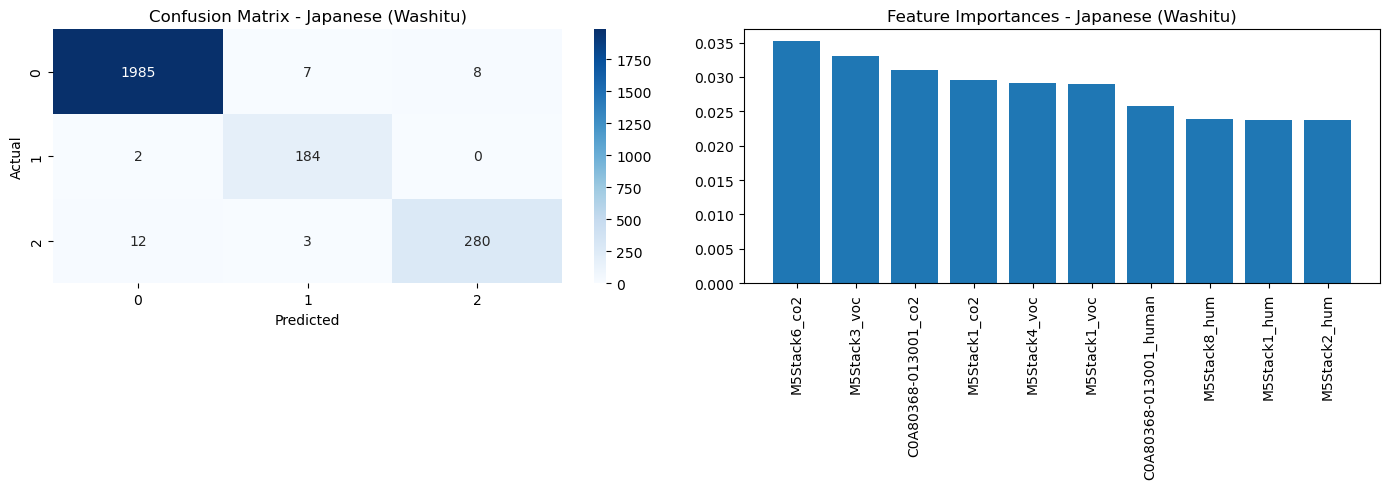

In [11]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
file_names = ["smart_home_0101.csv", "smart_home_1229-1.csv", "smart_home_1231.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプでソート
if 'timestamp' in full_data.columns:
    full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
    full_data = full_data.sort_values('timestamp').reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
full_data.ffill(inplace=True)
full_data.fillna(0, inplace=True)

# 特徴量の自動選択 (全センサーを使用)
sensor_cols = [c for c in full_data.columns if any(x in c for x in ['_co2', '_temp', '_hum', '_voc', '_pm2_5'])]
pir_cols = [c for c in full_data.columns if 'PIR' in c]
features = sensor_cols + pir_cols

print(f"使用する特徴量の数: {len(features)}")

# ==============================================================================
# 3. データオーグメンテーション関数
# ==============================================================================
def augment_data(X, y, noise_level=0.05, shift_steps=[-1, 1]):
    X_aug_list = [X]
    y_aug_list = [y]

    # 1. ノイズ付加
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # 2. タイムシフト
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(y_aug_list, ignore_index=True)

# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    'Living': 'Label_Living_Count',
    'Japanese (Washitu)': 'Label_Japanese_Count'
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "="*60)
    print(f" {room_name} の人数推定を開始します (Target: {target_col})")
    print("="*60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"エラー: {target_col} がデータに含まれていません。スキップします。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features]
    y = df_model[target_col]

    # Boolean -> Int
    for col in X.select_dtypes(include=['bool']).columns:
        X.loc[:, col] = X[col].astype(int)

    # 分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # データ拡張
    print(f"[{room_name}] データ拡張中...")
    X_train_aug, y_train_aug = augment_data(X_train, y_train, noise_level=0.05, shift_steps=[-1, 1])
    print(f"[{room_name}] 学習データ数: {len(X_train_aug)}")

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 混同行列
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {room_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)

    plt.tight_layout()
    plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 1. データ準備（ここはご自身の環境に合わせてください）
# ==========================================
# df = pd.read_csv("your_data.csv")
# X = df[['co2', 'temperature', 'pir', ...]]
# y = df['Label_Japanese_Count']
# ==========================================

# ★修正1: 警告対策（SettingWithCopyWarning）
# 明示的に .copy() することで、メモリ上で独立させます
X = X.copy()
y = y.copy()

print("============================================================")
print("Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)")
print("============================================================")

# ★修正2: 警告対策（FutureWarning / Boolean型）
# True/False の列を 1/0 に変換する処理（もしあれば）
# .locなどは使わず、シンプルに列全体を更新します
# （数値データだけの列ならこの処理はスキップされます）
for col in X.select_dtypes(include=["bool"]).columns:
    X[col] = X[col].astype(int)

# ★修正3: 警告対策（fillnaの古い書き方を修正）
# もしラグ特徴量（1つ前のデータなど）を作っている場合
# X_shifted = X.shift(1).fillna(method='bfill') # ← 古い書き方
# X_shifted = X.shift(1).bfill().ffill()        # ← 新しい書き方（例として記載）

# ------------------------------------------------------------
# 2. データの分割（時系列を考慮）
# ------------------------------------------------------------
# ★修正4: カンニング防止 (shuffle=False)
# 過去のデータで学習し、未来のデータを予測させます
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42  # ← ここをFalseにするのが重要！
)

print(f"[Japanese (Washitu)] 学習データ数: {len(X_train)}")
print(f"[Japanese (Washitu)] テストデータ数: {len(X_test)}")

# ------------------------------------------------------------
# 3. モデル学習
# ------------------------------------------------------------
print("[Japanese (Washitu)] モデル学習中...")

# ★修正5: 不均衡データ対策 (class_weight='balanced')
# 人数が少ないクラス（2人など）を間違えたときに、ペナルティを重くします
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",  # ← これで「見逃し」が減ります
    n_jobs=-1,  # 計算を並列化して高速化
)

model.fit(X_train, y_train)

# ------------------------------------------------------------
# 4. 評価
# ------------------------------------------------------------
y_pred = model.predict(X_test)

print(f"★ Japanese (Washitu) 正解率 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print("\n--- 詳細レポート ---")
print(classification_report(y_test, y_pred))

# 特徴量の重要度を表示（任意）
# どのセンサが役に立ったかがわかります
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)
print("\n--- 重要なセンサ Top 5 ---")
print(importances.head(5))

Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] 学習データ数: 6616
[Japanese (Washitu)] テストデータ数: 1654
[Japanese (Washitu)] モデル学習中...
★ Japanese (Washitu) 正解率 (Accuracy): 0.7146

--- 詳細レポート ---
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1251
           1       0.00      0.00      0.00         0
           2       1.00      0.10      0.18       403

    accuracy                           0.71      1654
   macro avg       0.59      0.34      0.34      1654
weighted avg       0.82      0.71      0.67      1654


--- 重要なセンサ Top 5 ---
M5Stack6_co2             0.079493
C0A80368-013001_human    0.073526
C0A80368-013001_co2      0.059090
M5Stack1_voc             0.057934
M5Stack5_voc             0.055704
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 1. 設定：ターゲット変数のリスト
# ==========================================
# ここに推定したいカラム名をリストで書きます
target_columns = [
    "Label_Japanese_Count",  # 和室の人数ラベル
    "Label_Living_Count",  # リビングの人数ラベル（カラム名が違う場合は修正してください）
]

# 説明変数（X）に含めたくないカラム（正解ラベルや時刻など）
drop_columns = target_columns + ["Datetime", "Timestamp"]  # 必要に応じて追加

# ==========================================
# 2. データ準備（修正版：数値データのみ自動抽出）
# ==========================================

# まず、ターゲット変数が含まれていないか確認して除外リストを作る
exclude_cols = target_columns.copy()

# ★ここが修正ポイント★
# データフレームから「数値（number）」と「真偽値（bool）」の列だけを抜き出します。
# これにより、'Datetime' や 'Timestamp' などの文字列カラムは自動的に捨てられます。
X_all = df.select_dtypes(include=["number", "bool"]).copy()

# もし X_all の中にターゲット変数（正解ラベル）が混ざっていたら削除
X_all = X_all.drop(
    columns=[c for c in exclude_cols if c in X_all.columns], errors="ignore"
)

# 確認用：どんなデータが残ったか表示
print(f"学習に使用するカラム数: {len(X_all.columns)}")
print("学習に使用するカラム一覧:", list(X_all.columns))

# 警告対策: Boolean型をintに変換
for col in X_all.select_dtypes(include=["bool"]).columns:
    X_all[col] = X_all[col].astype(int)
# ==========================================
# 3. ループ処理：部屋ごとに学習・評価
# ==========================================
for target in target_columns:

    if target not in df.columns:
        print(f"\n[Skip] {target} というカラムが見つからないためスキップします。")
        continue

    print("\n" + "=" * 60)
    print(f"★ {target} の推定を開始します")
    print("=" * 60)

    # 正解データ y を取得
    y = df[target].copy()

    # 欠損値がある行は削除（yがNaNだと学習できないため）
    # Xとyのインデックスを合わせて削除する必要があります
    valid_indices = y.dropna().index
    X_subset = X_all.loc[valid_indices]
    y_subset = y.loc[valid_indices]

    # --------------------------------------------------------
    # 時系列分割 (Shuffle=False)
    # --------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset,
        y_subset,
        test_size=0.2,
        shuffle=False,  # 時系列順を維持（カンニング防止）
        random_state=42,
    )

    print(f"学習データ数: {len(X_train)}")
    print(f"テストデータ数: {len(X_test)}")

    # --------------------------------------------------------
    # モデル学習
    # --------------------------------------------------------
    print("モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced",  # 少数派クラス（2人など）を重視
        n_jobs=-1,
    )

    model.fit(X_train, y_train)

    # --------------------------------------------------------
    # 評価
    # --------------------------------------------------------
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"★ {target} 正解率 (Accuracy): {acc:.4f}")

    print("\n--- 詳細レポート ---")
    # zero_division=0 で警告を抑制（データがないクラスは0と表示）
    print(classification_report(y_test, y_pred, zero_division=0))

    # 重要なセンサ Top 5
    print("--- 重要なセンサ Top 5 ---")
    importances = pd.Series(
        model.feature_importances_, index=X_subset.columns
    ).sort_values(ascending=False)
    print(importances.head(5))

学習に使用するカラム数: 192
学習に使用するカラム一覧: ['Label_Total_People', 'Label_Kitchen_Count', 'Label_Kitchen_Action', 'Label_Entrance_Count', 'Label_Entrance_Action', 'Label_Toilet1F_Count', 'Label_Toilet1F_Action', 'Label_Washroom_Count', 'Label_Washroom_Action', 'Label_Master_Count', 'Label_Toilet2F_Count', 'Label_Toilet2F_Action', 'Label_West1_Count', 'Label_West1_Action', 'Label_West2_Count', 'Label_West2_Action', 'Label_Spare_Count', 'Label_Spare_Action', 'Label_Hall_Count', 'Label_Hall_Action', 'PIR1_motion', 'PIR2_motion', 'PIR3_motion', 'PIR4_motion', 'PIR18_motion', 'PIR13_motion', 'PIR11_motion', 'PIR5_motion', 'PIR21_motion', 'PIR17_motion', 'PIR6_motion', 'PIR8_motion', 'PIR9_motion', 'PIR10_motion', 'PIR15_motion', 'PIR19_motion', 'PIR20_motion', 'PIR22_motion', 'PIR24_motion', 'M5Stack1_co2', 'M5Stack1_temp', 'M5Stack1_hum', 'M5Stack1_pm2_5', 'M5Stack1_voc', 'M5Stack2_co2', 'M5Stack2_temp', 'M5Stack2_hum', 'M5Stack2_pm2_5', 'M5Stack2_voc', 'M5Stack3_co2', 'M5Stack3_temp', 'M5Stack3_hum', 

データを読み込んでいます...
 - smart_home_0101.csv: 読み込み完了 (1786 行)
 - smart_home_1229-1.csv: 読み込み完了 (3389 行)
 - smart_home_1231.csv: 読み込み完了 (3095 行)
使用する特徴量の数: 81

★ Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張を実行中...
[Living] 学習データ数: 5789 => 40523 (約7.0倍)
[Living] モデル学習中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/1216728903.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data = full_data.bfill().ffill().fillna(0)



★ Living 正解率 (Accuracy): 0.9170
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1676
           1       0.87      0.90      0.88       310
           2       0.90      0.80      0.85       495

    accuracy                           0.92      2481
   macro avg       0.90      0.89      0.89      2481
weighted avg       0.92      0.92      0.92      2481



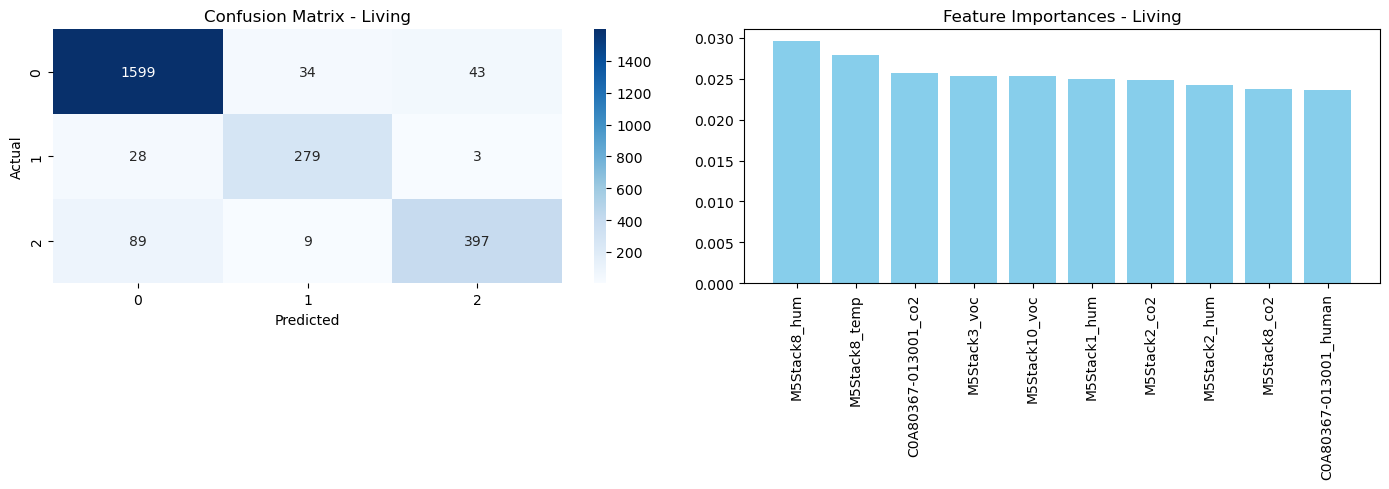


★ Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張を実行中...
[Japanese (Washitu)] 学習データ数: 5789 => 40523 (約7.0倍)
[Japanese (Washitu)] モデル学習中...

★ Japanese (Washitu) 正解率 (Accuracy): 0.9597
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2000
           1       0.90      0.97      0.94       186
           2       0.90      0.82      0.86       295

    accuracy                           0.96      2481
   macro avg       0.92      0.92      0.92      2481
weighted avg       0.96      0.96      0.96      2481



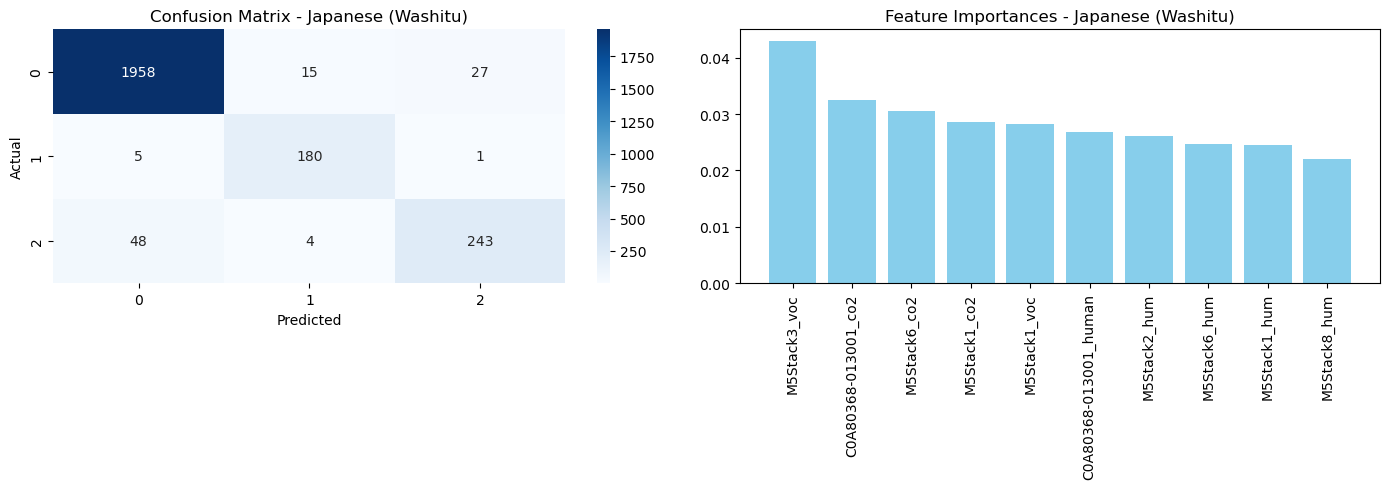


全ての処理が完了しました。


In [12]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 日本語フォント設定（Mac用: AppleGothic, Windows用: Meiryoなど適宜変更）
# plt.rcParams['font.family'] = 'AppleGothic'

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
# ★ここに読み込みたいファイル名をリストで記述してください
file_names = ["smart_home_0101.csv", "smart_home_1229-1.csv", "smart_home_1231.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプがあればソート（時系列順に整列）
if "timestamp" in full_data.columns:
    full_data["timestamp"] = pd.to_datetime(full_data["timestamp"])
    full_data = full_data.sort_values("timestamp").reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
# 欠損値補完（新しい書き方）
full_data = full_data.bfill().ffill().fillna(0)

# 特徴量の自動選択 (全センサーを使用)
# "_co2", "_temp" などが含まれる列と "PIR" が含まれる列を抽出
sensor_cols = [
    c
    for c in full_data.columns
    if any(x in c for x in ["_co2", "_temp", "_hum", "_voc", "_pm2_5"])
]
pir_cols = [c for c in full_data.columns if "PIR" in c]

# ここで数値データ以外（文字列など）が混ざらないようにフィルタリング
numeric_cols_only = full_data.select_dtypes(include=["number", "bool"]).columns
features = [c for c in (sensor_cols + pir_cols) if c in numeric_cols_only]

print(f"使用する特徴量の数: {len(features)}")
# print(features) # 特徴量の中身を見たい場合はコメントアウトを外す


# ==============================================================================
# 3. 強化版データオーグメンテーション関数
# ==============================================================================
def augment_data_enhanced(
    X, y, noise_level=0.05, shift_steps=[-2, -1, 1, 2], scaling_range=(0.95, 1.05)
):
    """
    データ拡張を行う関数（強化版）
    1. ノイズ付加: センサーの微細な揺らぎを再現
    2. タイムシフト: 応答遅れや早まりを再現（範囲拡大）
    3. スケーリング: センサー感度の個体差や環境差を再現
    """
    X_aug_list = [X]
    y_aug_list = [y]

    # 数値カラムのみ抽出（計算エラー防止）
    numeric_cols = X.select_dtypes(include=[np.number]).columns

    # --- 1. ノイズ付加 (Gaussian Noise) ---
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # --- 2. タイムシフト (Time Shift) ---
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    # --- 3. スケーリング (Scaling) ---
    # 値全体をランダムに 0.95倍 ~ 1.05倍 する
    factor = np.random.uniform(scaling_range[0], scaling_range[1])
    X_scaled = X.copy()
    X_scaled[numeric_cols] = X_scaled[numeric_cols] * factor
    X_aug_list.append(X_scaled)
    y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(
        y_aug_list, ignore_index=True
    )


# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    "Living": "Label_Living_Count",  # リビングの正解ラベル
    "Japanese (Washitu)": "Label_Japanese_Count",  # 和室の正解ラベル
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "=" * 60)
    print(f"★ {room_name} の人数推定を開始します (Target: {target_col})")
    print("=" * 60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"[Skip] {target_col} がデータに含まれていません。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features].copy()
    y = df_model[target_col].copy()

    # Boolean -> Int 変換
    for col in X.select_dtypes(include=["bool"]).columns:
        X[col] = X[col].astype(int)

    # データの分割 (Shuffle=True で多様なパターンを学習)
    # ※時系列を厳密に見るなら shuffle=False にしてください
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=True
    )

    # データ拡張の実行
    print(f"[{room_name}] データ拡張を実行中...")
    original_size = len(X_train)

    # 強化版関数を使用
    X_train_aug, y_train_aug = augment_data_enhanced(
        X_train,
        y_train,
        noise_level=0.05,
        shift_steps=[-2, -1, 1, 2],
        scaling_range=(0.95, 1.05),
    )

    print(
        f"[{room_name}] 学習データ数: {original_size} => {len(X_train_aug)} (約{len(X_train_aug)/original_size:.1f}倍)"
    )

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",  # 少数派クラス（2人など）を重視
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")

    # warningが出ないように zero_division=0 を設定
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 1. 混同行列 (Confusion Matrix)
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {room_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # 2. 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10

    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center", color="skyblue")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

print("\n全ての処理が完了しました。")

Loading data from smart_home_merged_all.csv...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1885823935.py:55: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")



分析対象: Label_Living_Count
全特徴量数: 154
CO2系カラム数: 10
PIR系カラム数: 21
その他カラム数: 123

==================== 1. CO2 Sensors Only ====================
Accuracy (正解率): 0.9958

Confusion Matrix (混同行列):
[[2494    3    5]
 [   5  772    2]
 [   1    1  799]]

Top 10 Important Features:
1. M5Stack2_co2: 0.1466
2. C0A80367-013001_co2: 0.1190
3. M5Stack8_co2: 0.1074
4. C0A80368-013001_co2: 0.1007
5. M5Stack6_co2: 0.0984
6. M5Stack10_co2: 0.0962
7. M5Stack4_co2: 0.0934
8. M5Stack3_co2: 0.0924
9. M5Stack1_co2: 0.0863
10. M5Stack5_co2: 0.0596

==================== 2. PIR Sensors Only ====================
Accuracy (正解率): 0.7411

Confusion Matrix (混同行列):
[[2357   22  123]
 [ 434  200  145]
 [ 236   97  468]]

Top 10 Important Features:
1. C0A80367-013001_human: 0.5186
2. PIR4_motion: 0.1953
3. C0A80368-013001_human: 0.1309
4. PIR3_motion: 0.0456
5. PIR1_motion: 0.0273
6. PIR2_motion: 0.0178
7. PIR21_motion: 0.0106
8. PIR17_motion: 0.0100
9. PIR8_motion: 0.0089
10. PIR24_motion: 0.0076

==================== 3.

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1885823935.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1885823935.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(feats), ax=ax3, palette="Blues_r")
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1885823935.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores_r), y=list(feats_r), ax=ax4, palette="Oranges_r")



分析完了！結果画像 'analysis_result_report.png' を保存しました。


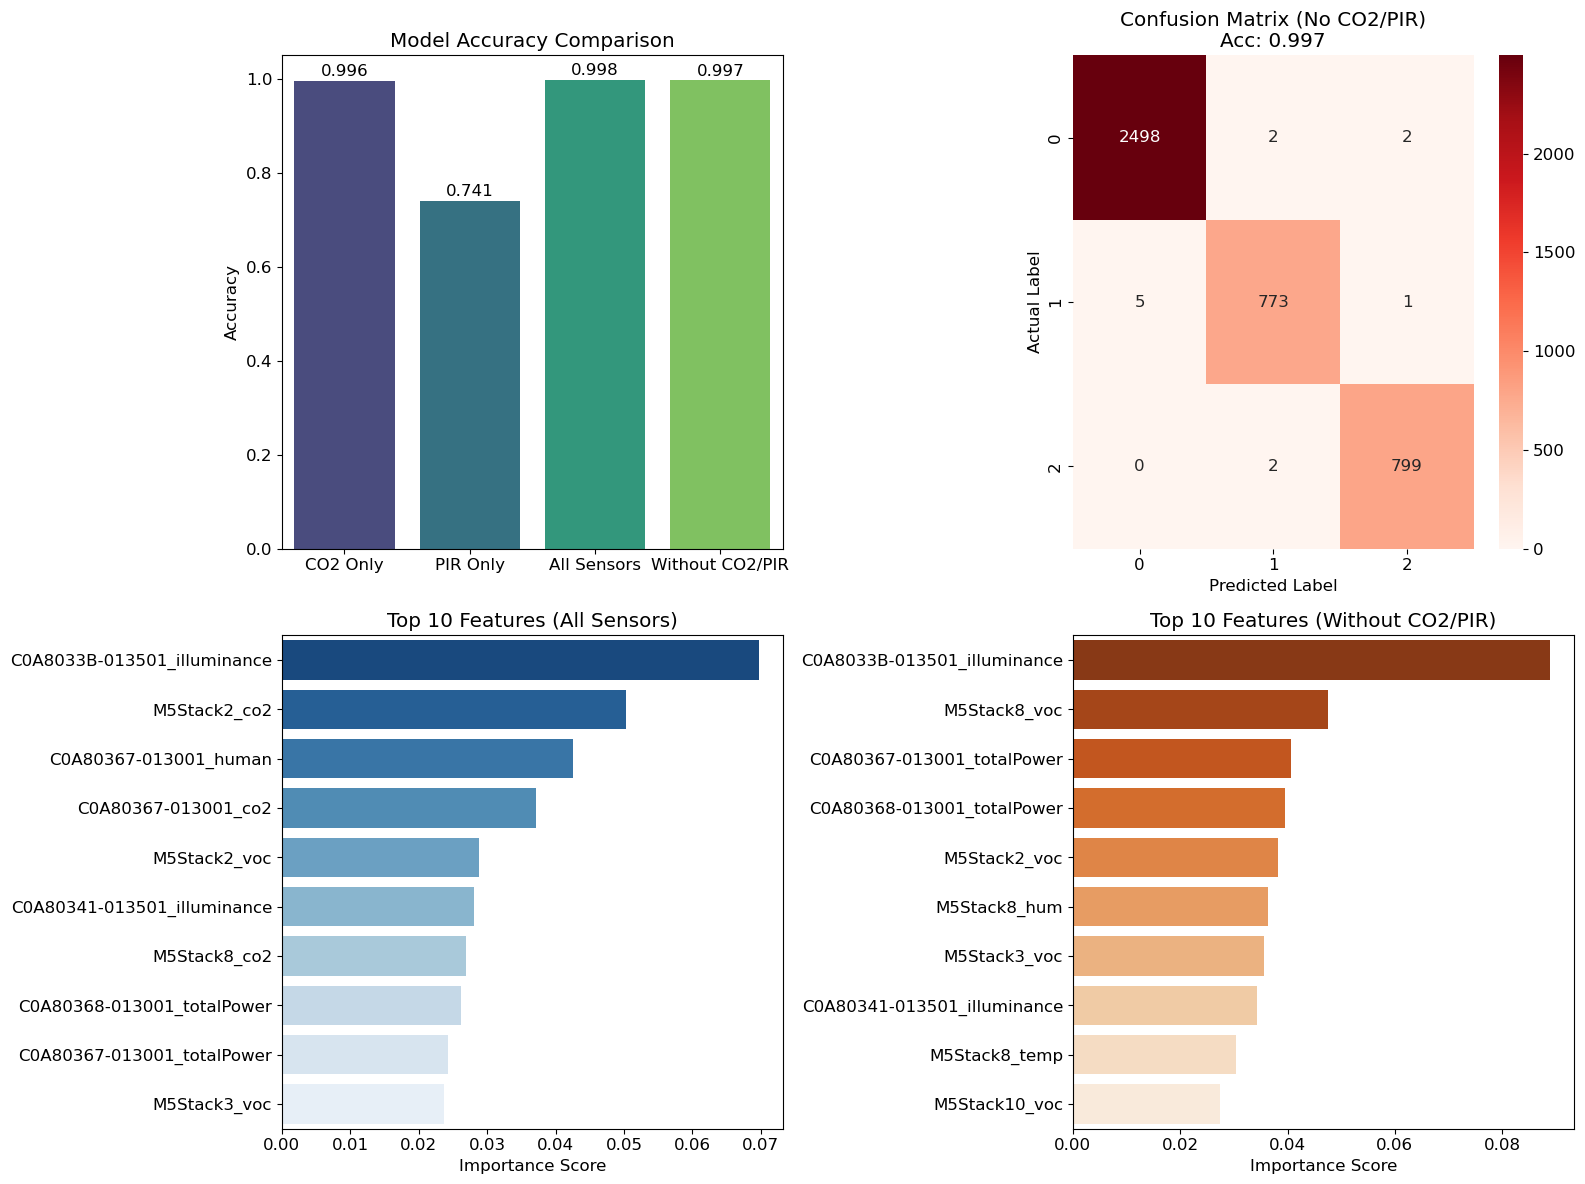

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 設定エリア
# ==========================================
FILE_PATH = "smart_home_merged_all.csv"  # 統合したデータファイル名
TARGET_COL = "Label_Living_Count"  # 推定したい正解ラベル（リビングの人数）
# TARGET_COL = "Label_Japanese_Count"    # 和室を分析したい場合はこちらに変更

# 出力する画像のサイズ設定
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12


def load_and_preprocess(file_path):
    print(f"Loading data from {file_path}...")
    try:
        # 警告を避けるためlow_memory=False
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError:
        print("エラー: ファイルが見つかりません。パスを確認してください。")
        return None, None

    # 1. タイムスタンプ処理（時系列順にソート）
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")
        df = df.drop(columns=["timestamp"])  # 学習には使わないので削除

    # 2. 正解ラベルのクリーニング
    # 欠損している行は削除
    df = df.dropna(subset=[TARGET_COL])
    # 整数型に変換
    df[TARGET_COL] = df[TARGET_COL].astype(int)

    # 3. 特徴量（X）の準備
    # 正解ラベル系のカラム（Label_...）を全て除外
    label_cols = [c for c in df.columns if "Label_" in c]
    X = df.drop(columns=label_cols)
    y = df[TARGET_COL]

    # 4. 数値化処理
    # 'True'/'False' や 'ON'/'OFF' などを数値に変換
    le = LabelEncoder()
    for col in X.columns:
        # まずは数値に変換してみる
        X[col] = pd.to_numeric(X[col], errors="ignore")

        # それでも文字列が残っている場合（カテゴリカルデータ）
        if X[col].dtype == "object":
            # ブール値の文字列対応
            if X[col].astype(str).str.lower().iloc[0] in ["true", "false"]:
                X[col] = (
                    X[col]
                    .astype(str)
                    .map(
                        {
                            "True": 1,
                            "False": 0,
                            "true": 1,
                            "false": 0,
                            "1.0": 1,
                            "0.0": 0,
                        }
                    )
                )
            else:
                # その他の文字列はラベルエンコーディング
                X[col] = X[col].astype(str)
                X[col] = le.fit_transform(X[col])

    # 5. 欠損値埋め（平均値で埋める）
    # 全てがNaNの列は削除
    X = X.dropna(axis=1, how="all")

    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    return X_imputed, y


def train_and_evaluate(X, y, feature_names, title="Model"):
    """
    ランダムフォレストで学習・評価し、結果を表示する関数
    """
    print(f"\n{'='*20} {title} {'='*20}")

    # データを分割
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # モデル構築
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # 予測
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy (正解率): {acc:.4f}")
    print("\nConfusion Matrix (混同行列):")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # 特徴量重要度
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]

        print("\nTop 10 Important Features:")
        top_features = []
        for i in range(min(10, len(feature_names))):
            feat_name = feature_names[indices[i]]
            score = importances[indices[i]]
            print(f"{i+1}. {feat_name}: {score:.4f}")
            top_features.append((feat_name, score))

        return clf, acc, cm, top_features
    return clf, acc, cm, []


def main():
    # データの読み込み
    X, y = load_and_preprocess(FILE_PATH)
    if X is None:
        return

    print(f"\n分析対象: {TARGET_COL}")
    print(f"全特徴量数: {len(X.columns)}")

    # ---------------------------------------------------------
    # 特徴量のグルーピング (カラム名から自動判定)
    # ---------------------------------------------------------
    # CO2関連: "co2" を含む
    cols_co2 = [c for c in X.columns if "co2" in c.lower()]

    # 人感センサ関連: "motion" または "human" を含む
    cols_pir = [c for c in X.columns if "motion" in c.lower() or "human" in c.lower()]

    # その他: 上記以外 (温度、湿度、VOC、家電ステータスなど)
    cols_other = [c for c in X.columns if c not in cols_co2 and c not in cols_pir]

    print(f"CO2系カラム数: {len(cols_co2)}")
    print(f"PIR系カラム数: {len(cols_pir)}")
    print(f"その他カラム数: {len(cols_other)}")

    # ---------------------------------------------------------
    # 先生からのリクエスト 1: CO2センサと人感センサとの比較
    # ---------------------------------------------------------
    results = {}

    # 1-1. CO2のみ
    if cols_co2:
        clf_co2, acc_co2, cm_co2, _ = train_and_evaluate(
            X[cols_co2], y, cols_co2, "1. CO2 Sensors Only"
        )
        results["CO2 Only"] = acc_co2
    else:
        print("\n※CO2カラムが見つかりませんでした。")

    # 1-2. 人感センサ(PIR)のみ
    if cols_pir:
        clf_pir, acc_pir, cm_pir, _ = train_and_evaluate(
            X[cols_pir], y, cols_pir, "2. PIR Sensors Only"
        )
        results["PIR Only"] = acc_pir
    else:
        print("\n※PIRカラムが見つかりませんでした。")

    # ---------------------------------------------------------
    # 先生からのリクエスト 2: CO2と人感センサを外した場合の分析
    # ---------------------------------------------------------

    # 2-1. 全センサ (Baseline)
    clf_all, acc_all, cm_all, top_all = train_and_evaluate(
        X, y, X.columns, "3. All Sensors (Baseline)"
    )
    results["All Sensors"] = acc_all

    # 2-2. CO2とPIRを除外 (Restricted)
    if cols_other:
        clf_rest, acc_rest, cm_rest, top_rest = train_and_evaluate(
            X[cols_other], y, cols_other, "4. Without CO2 & PIR"
        )
        results["Without CO2/PIR"] = acc_rest
    else:
        print("\n※その他のセンサが見つかりませんでした。")

    # ---------------------------------------------------------
    # 結果の可視化
    # ---------------------------------------------------------
    print("\nGraphs generating...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. 精度比較の棒グラフ
    ax1 = axes[0, 0]
    sns.barplot(
        x=list(results.keys()), y=list(results.values()), ax=ax1, palette="viridis"
    )
    ax1.set_ylim(0, 1.05)
    ax1.set_title("Model Accuracy Comparison")
    ax1.set_ylabel("Accuracy")
    for i, v in enumerate(results.values()):
        ax1.text(i, v + 0.01, f"{v:.3f}", ha="center")

    # 2. 混同行列 (Without CO2 & PIR) - 一番興味深い結果
    ax2 = axes[0, 1]
    if "cols_other" in locals() and cols_other:
        sns.heatmap(cm_rest, annot=True, fmt="d", cmap="Reds", ax=ax2)
        ax2.set_title(f"Confusion Matrix (No CO2/PIR)\nAcc: {acc_rest:.3f}")
        ax2.set_ylabel("Actual Label")
        ax2.set_xlabel("Predicted Label")

    # 3. 特徴量重要度 (全センサ)
    ax3 = axes[1, 0]
    if top_all:
        feats, scores = zip(*top_all)
        sns.barplot(x=list(scores), y=list(feats), ax=ax3, palette="Blues_r")
        ax3.set_title("Top 10 Features (All Sensors)")
        ax3.set_xlabel("Importance Score")

    # 4. 特徴量重要度 (CO2/PIRなし) - 代替センサの特定
    ax4 = axes[1, 1]
    if "top_rest" in locals() and top_rest:
        feats_r, scores_r = zip(*top_rest)
        sns.barplot(x=list(scores_r), y=list(feats_r), ax=ax4, palette="Oranges_r")
        ax4.set_title("Top 10 Features (Without CO2/PIR)")
        ax4.set_xlabel("Importance Score")

    plt.tight_layout()
    plt.savefig("analysis_result_report.png")
    print("\n分析完了！結果画像 'analysis_result_report.png' を保存しました。")


if __name__ == "__main__":
    main()


--- Loading data for target: Label_Living_Count ---


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:56: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


[Living_Room] Total Features: 154
  CO2: 10, PIR: 21, Others: 123
Training Living_Room - All Sensors...
Training Living_Room - CO2 Only...
Training Living_Room - PIR Only...
Training Living_Room - No CO2/PIR...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(feats), ax=axes[1, 0], palette="Blues_r")
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Saved graph: analysis_Living_Room.png

--- Summary ---
Base Accuracy: 0.9980
Restricted Accuracy: 0.9971
Top Features without CO2/PIR:
 - C0A8033B-013501_illuminance: 0.0889
 - M5Stack8_voc: 0.0475
 - C0A80367-013001_totalPower: 0.0406
 - C0A80368-013001_totalPower: 0.0395
 - M5Stack2_voc: 0.0382
------------------------------

--- Loading data for target: Label_Japanese_Count ---


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:56: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


[Japanese_Room] Total Features: 154
  CO2: 10, PIR: 21, Others: 123
Training Japanese_Room - All Sensors...
Training Japanese_Room - CO2 Only...
Training Japanese_Room - PIR Only...
Training Japanese_Room - No CO2/PIR...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(feats), ax=axes[1, 0], palette="Blues_r")
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1904160847.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Saved graph: analysis_Japanese_Room.png

--- Summary ---
Base Accuracy: 0.9973
Restricted Accuracy: 0.9978
Top Features without CO2/PIR:
 - C0A80341-013501_illuminance: 0.0828
 - C0A80367-013001_totalPower: 0.0501
 - C0A80368-013001_totalPower: 0.0421
 - C0A8033B-013501_illuminance: 0.0384
 - M5Stack1_voc: 0.0356
------------------------------


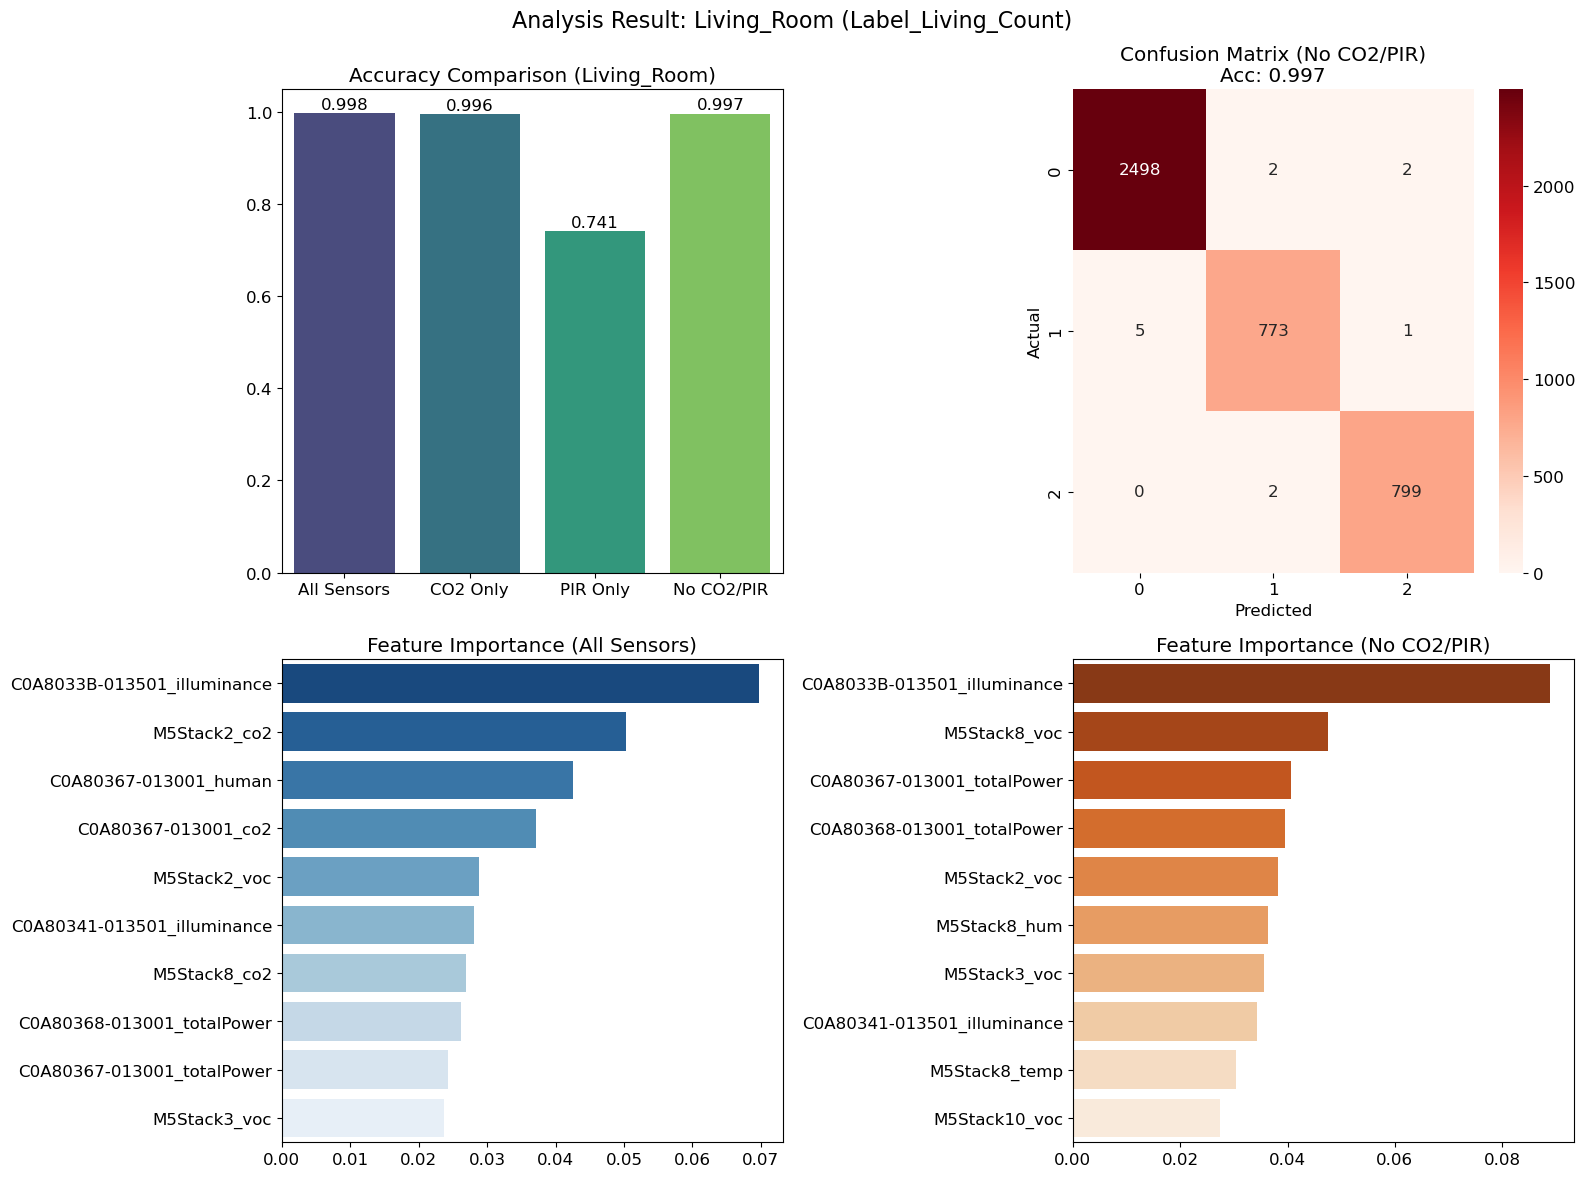

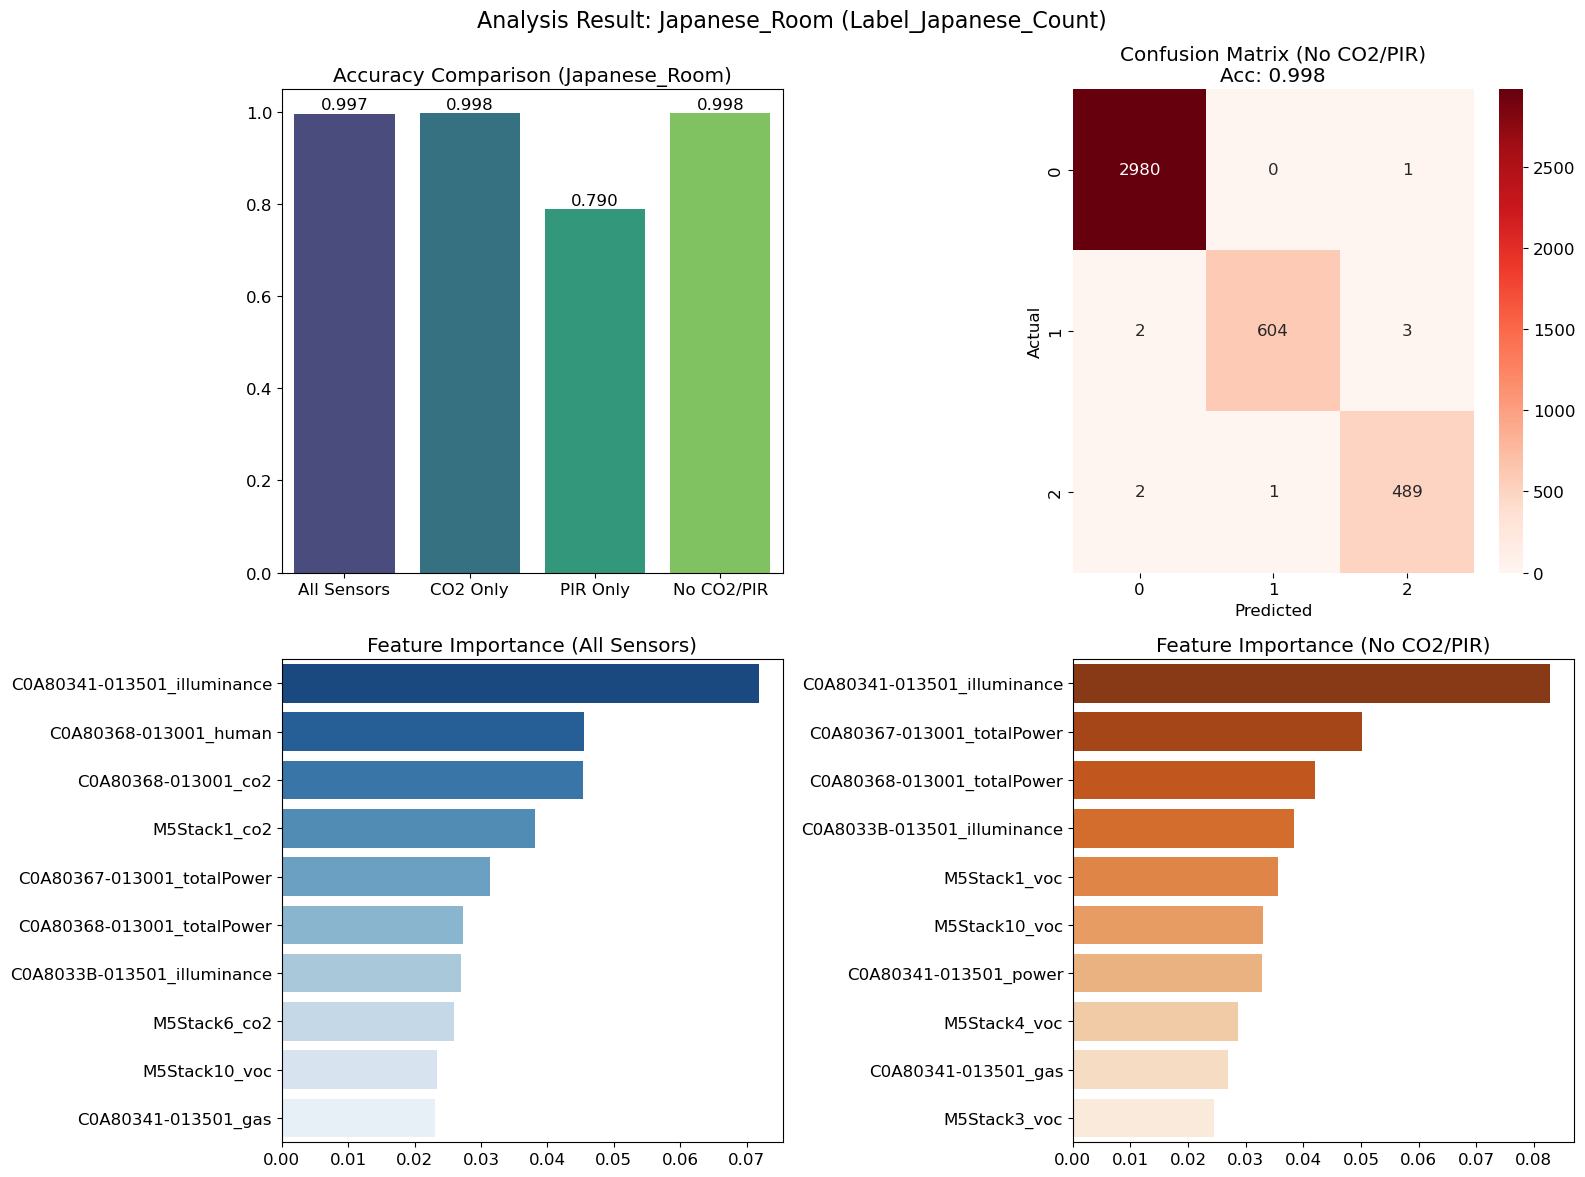

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 設定エリア
# ==========================================
FILE_PATH = "smart_home_merged_all.csv"  # データファイル名

# グラフのスタイル設定
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "sans-serif"  # 日本語対応フォントがあれば指定推奨


def load_and_preprocess(file_path, target_col):
    """
    データの読み込みと前処理を行う関数
    target_col: 推定したい正解ラベルのカラム名
    """
    print(f"\n--- Loading data for target: {target_col} ---")
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError:
        print("エラー: ファイルが見つかりません。")
        return None, None

    # 1. タイムスタンプ順ソート
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")
        df = df.drop(columns=["timestamp"])

    # 2. 正解ラベルのクリーニング
    # 欠損行を削除
    df = df.dropna(subset=[target_col])
    # 人数が小数になっている可能性も考慮して整数化
    df[target_col] = df[target_col].astype(int)

    # 3. 特徴量(X)と正解(y)の分離
    # 正解ラベル系のカラム（Label_...）を全て除外して特徴量にする
    label_cols = [c for c in df.columns if "Label_" in c]
    X = df.drop(columns=label_cols)
    y = df[target_col]

    # 4. 数値化処理 (カテゴリカルデータの変換)
    le = LabelEncoder()
    for col in X.columns:
        # 数値変換を試みる
        X[col] = pd.to_numeric(X[col], errors="ignore")

        # 文字列が残っている場合
        if X[col].dtype == "object":
            # True/Falseの文字列対応
            sample = X[col].astype(str).str.lower().iloc[0] if len(X) > 0 else ""
            if sample in ["true", "false"]:
                X[col] = (
                    X[col]
                    .astype(str)
                    .map(
                        {
                            "True": 1,
                            "False": 0,
                            "true": 1,
                            "false": 0,
                            "1.0": 1,
                            "0.0": 0,
                        }
                    )
                )
            else:
                # その他の文字列はラベルエンコーディング（欠損値は'Unknown'扱い）
                X[col] = X[col].fillna("Unknown").astype(str)
                X[col] = le.fit_transform(X[col])

    # 5. 欠損値埋め
    # 全てNaNの列は削除
    X = X.dropna(axis=1, how="all")

    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    return X_imputed, y


def train_and_evaluate(X, y, feature_names, title):
    """
    ランダムフォレストで学習・評価する関数
    """
    if X.empty:
        print(f"Warning: No features available for {title}")
        return None, 0, [], []

    # データ分割
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # モデル構築
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # 予測
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # 特徴量重要度
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_features = []
    for i in range(min(15, len(feature_names))):
        feat = feature_names[indices[i]]
        score = importances[indices[i]]
        top_features.append((feat, score))

    return clf, acc, cm, top_features


def analyze_room(target_col, room_name):
    """
    指定された部屋（ターゲット）に対して分析を実行する関数
    """
    X, y = load_and_preprocess(FILE_PATH, target_col)
    if X is None:
        return

    # カラムのグルーピング
    cols_co2 = [c for c in X.columns if "co2" in c.lower()]
    cols_pir = [c for c in X.columns if "motion" in c.lower() or "human" in c.lower()]
    cols_other = [c for c in X.columns if c not in cols_co2 and c not in cols_pir]

    print(f"[{room_name}] Total Features: {len(X.columns)}")
    print(f"  CO2: {len(cols_co2)}, PIR: {len(cols_pir)}, Others: {len(cols_other)}")

    results = {}

    # 1. 全センサ (Baseline)
    print(f"Training {room_name} - All Sensors...")
    _, acc_all, cm_all, top_all = train_and_evaluate(X, y, X.columns, "All Sensors")
    results["All Sensors"] = acc_all

    # 2. CO2のみ
    print(f"Training {room_name} - CO2 Only...")
    _, acc_co2, _, _ = train_and_evaluate(X[cols_co2], y, cols_co2, "CO2 Only")
    results["CO2 Only"] = acc_co2

    # 3. PIRのみ
    print(f"Training {room_name} - PIR Only...")
    _, acc_pir, _, _ = train_and_evaluate(X[cols_pir], y, cols_pir, "PIR Only")
    results["PIR Only"] = acc_pir

    # 4. CO2 & PIR なし (Other)
    print(f"Training {room_name} - No CO2/PIR...")
    _, acc_rest, cm_rest, top_rest = train_and_evaluate(
        X[cols_other], y, cols_other, "No CO2/PIR"
    )
    results["No CO2/PIR"] = acc_rest

    # --- グラフ描画 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Analysis Result: {room_name} ({target_col})", fontsize=16)

    # 1. 精度比較
    sns.barplot(
        x=list(results.keys()),
        y=list(results.values()),
        ax=axes[0, 0],
        palette="viridis",
    )
    axes[0, 0].set_title(f"Accuracy Comparison ({room_name})")
    axes[0, 0].set_ylim(0, 1.05)
    for i, v in enumerate(results.values()):
        axes[0, 0].text(i, v + 0.01, f"{v:.3f}", ha="center")

    # 2. 混同行列 (No CO2/PIR)
    sns.heatmap(cm_rest, annot=True, fmt="d", cmap="Reds", ax=axes[0, 1])
    axes[0, 1].set_title(f"Confusion Matrix (No CO2/PIR)\nAcc: {acc_rest:.3f}")
    axes[0, 1].set_xlabel("Predicted")
    axes[0, 1].set_ylabel("Actual")

    # 3. 特徴量重要度 (Top 10 - All)
    if top_all:
        feats, scores = zip(*top_all[:10])
        sns.barplot(x=list(scores), y=list(feats), ax=axes[1, 0], palette="Blues_r")
        axes[1, 0].set_title("Feature Importance (All Sensors)")

    # 4. 特徴量重要度 (Top 10 - No CO2/PIR)
    if top_rest:
        feats_r, scores_r = zip(*top_rest[:10])
        sns.barplot(
            x=list(scores_r), y=list(feats_r), ax=axes[1, 1], palette="Oranges_r"
        )
        axes[1, 1].set_title("Feature Importance (No CO2/PIR)")

    plt.tight_layout()
    plt.savefig(f"analysis_{room_name}.png")
    print(f"Saved graph: analysis_{room_name}.png")

    # コンソール出力
    print("\n--- Summary ---")
    print(f"Base Accuracy: {acc_all:.4f}")
    print(f"Restricted Accuracy: {acc_rest:.4f}")
    print("Top Features without CO2/PIR:")
    for f, s in top_rest[:5]:
        print(f" - {f}: {s:.4f}")
    print("-" * 30)


def main():
    # リビングの分析
    analyze_room("Label_Living_Count", "Living_Room")

    # 和室の分析
    analyze_room("Label_Japanese_Count", "Japanese_Room")


if __name__ == "__main__":
    main()

Loading data from smart_home_merged_all.csv...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:61: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")



==================== Living_Room の分析 ====================
Overall Accuracy: 0.9980

--- クラス別 (0人, 1人, 2人) の詳細レポート ---
              precision    recall  f1-score   support

          0人       1.00      1.00      1.00      2502
          1人       1.00      0.99      1.00       779
          2人       1.00      1.00      1.00       801

    accuracy                           1.00      4082
   macro avg       1.00      1.00      1.00      4082
weighted avg       1.00      1.00      1.00      4082

結果画像を保存しました: ./result_Living_Room.png


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_feats, ax=axes[1], palette="viridis")
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:141: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:141: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:141: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937

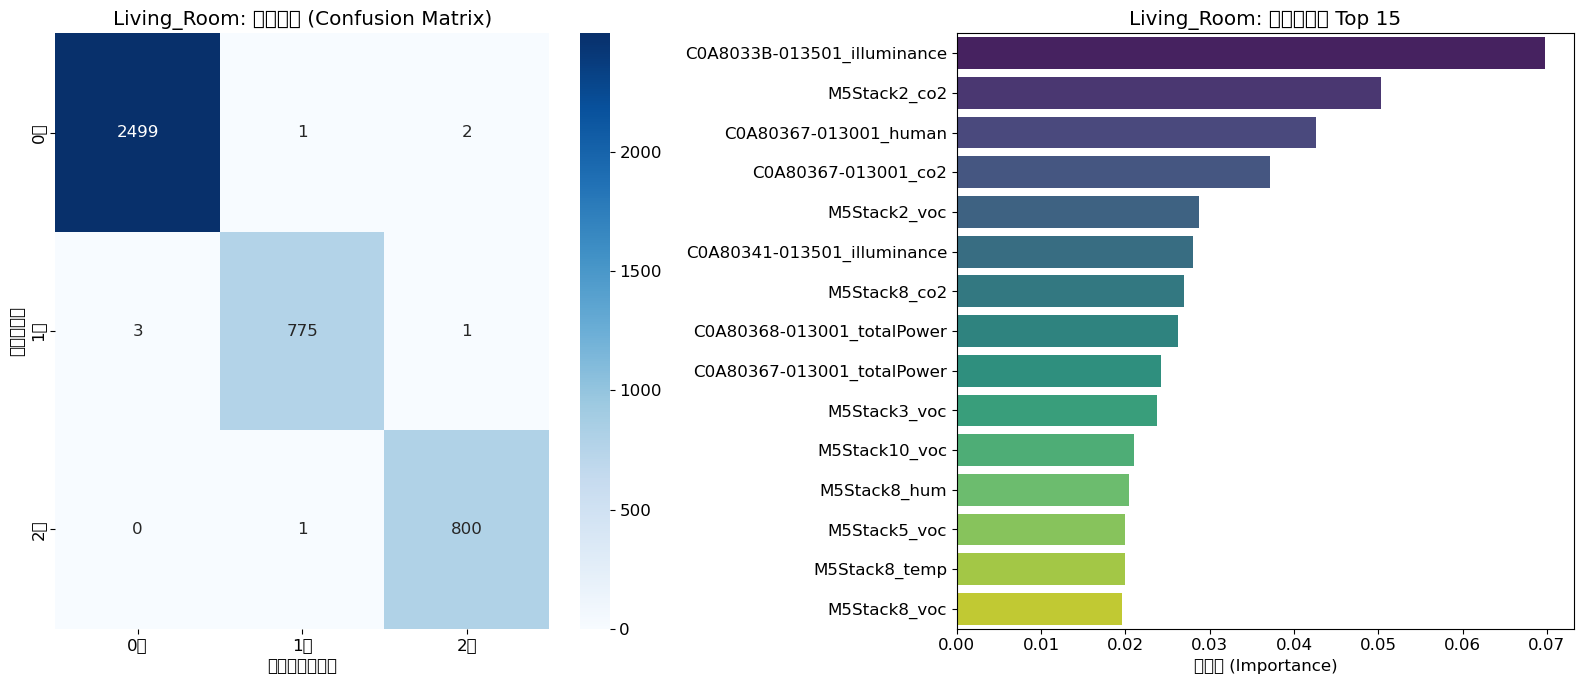

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:61: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")



==================== Japanese_Room の分析 ====================
Overall Accuracy: 0.9973

--- クラス別 (0人, 1人, 2人) の詳細レポート ---
              precision    recall  f1-score   support

          0人       1.00      1.00      1.00      2981
          1人       1.00      0.99      1.00       609
          2人       0.99      0.99      0.99       492

    accuracy                           1.00      4082
   macro avg       1.00      0.99      0.99      4082
weighted avg       1.00      1.00      1.00      4082

結果画像を保存しました: ./result_Japanese_Room.png


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_feats, ax=axes[1], palette="viridis")
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:141: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:141: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937.py:141: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1064610937

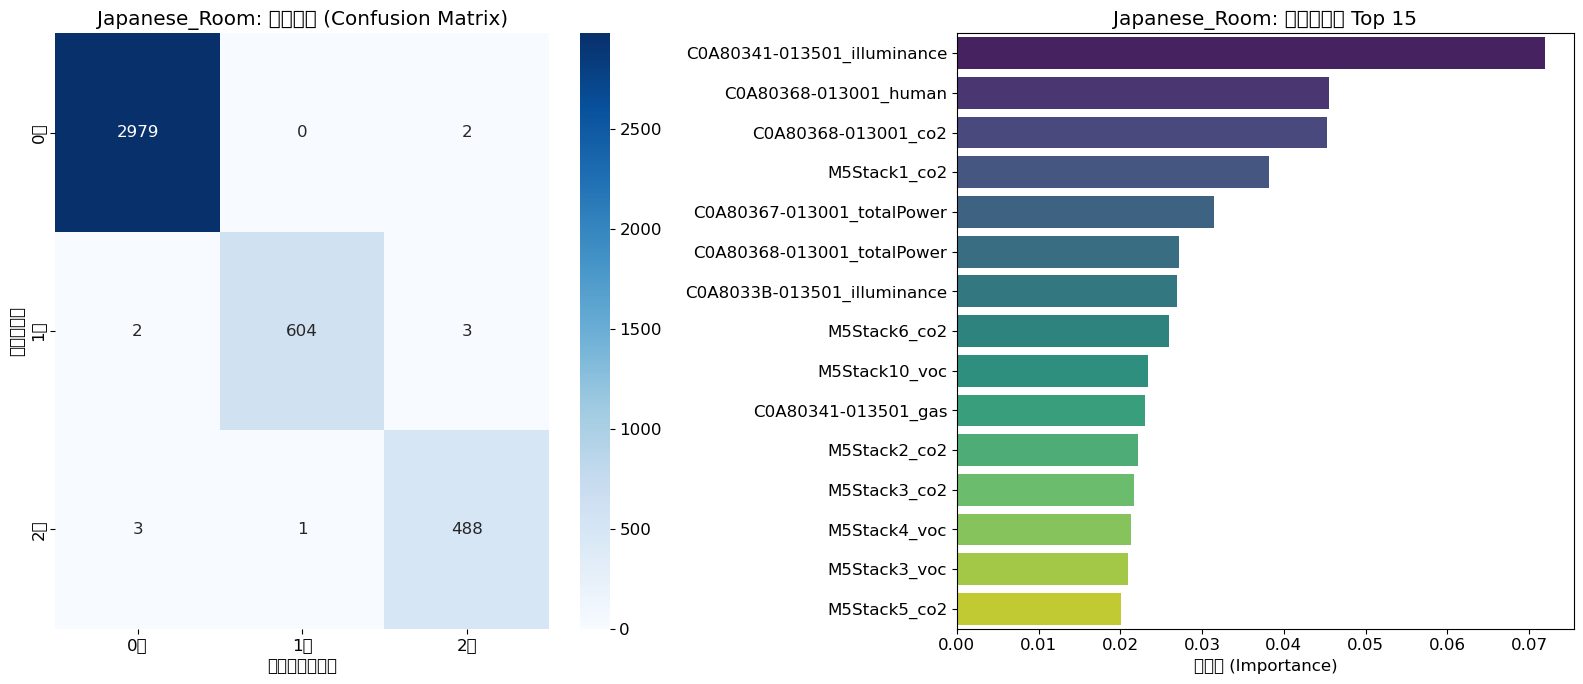

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 設定エリア
# ==========================================
FILE_PATH = "smart_home_merged_all.csv"  # データファイル名
OUTPUT_IMAGE_DIR = "."  # 画像の保存先

# グラフのスタイル設定
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 12


def load_and_preprocess(file_path):
    """データの読み込みと前処理"""
    print(f"Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError:
        print("エラー: ファイルが見つかりません。")
        return None

    # タイムスタンプ順ソート
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")
        df = df.drop(columns=["timestamp"])

    return df


def prepare_data(df, target_col):
    """指定されたターゲット（部屋の人数）用にデータを整形"""
    # 正解ラベルが欠損している行は削除
    df_clean = df.dropna(subset=[target_col]).copy()

    # 人数は整数型にする (0.0 -> 0)
    df_clean[target_col] = df_clean[target_col].astype(int)

    # 0, 1, 2人のデータのみに絞る（異常値や3人以上のデータを除外する場合）
    df_clean = df_clean[df_clean[target_col].isin([0, 1, 2])]

    # 特徴量 (X) と正解 (y) の分離
    # "Label_" で始まるカラムは全て正解情報なので特徴量から外す
    label_cols = [c for c in df_clean.columns if "Label_" in c]
    X = df_clean.drop(columns=label_cols)
    y = df_clean[target_col]

    # 数値化処理
    le = LabelEncoder()
    for col in X.columns:
        # 数値変換
        X[col] = pd.to_numeric(X[col], errors="ignore")
        # 文字列が残っている場合
        if X[col].dtype == "object":
            # True/False対応
            sample = X[col].astype(str).str.lower().iloc[0] if len(X) > 0 else ""
            if sample in ["true", "false"]:
                X[col] = (
                    X[col]
                    .astype(str)
                    .map(
                        {
                            "True": 1,
                            "False": 0,
                            "true": 1,
                            "false": 0,
                            "1.0": 1,
                            "0.0": 0,
                        }
                    )
                )
            else:
                # その他のカテゴリ
                X[col] = X[col].fillna("Unknown").astype(str)
                X[col] = le.fit_transform(X[col])

    # 欠損値埋め（平均値）
    X = X.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    return X_imputed, y


def train_evaluate_analyze(X, y, room_name):
    """学習、評価、可視化を一括で行う"""
    print(f"\n{'='*20} {room_name} の分析 {'='*20}")

    # データ分割
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # モデル構築 (ランダムフォレスト)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # 予測
    y_pred = clf.predict(X_test)

    # --- 1. 結果の数値出力 ---
    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\n--- クラス別 (0人, 1人, 2人) の詳細レポート ---")
    # target_namesを指定して見やすくする
    print(classification_report(y_test, y_pred, target_names=["0人", "1人", "2人"]))

    # --- 2. グラフ描画 ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # 混同行列 (Confusion Matrix)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{room_name}: 混同行列 (Confusion Matrix)")
    axes[0].set_xlabel("予測された人数")
    axes[0].set_ylabel("実際の人数")
    axes[0].set_xticklabels(["0人", "1人", "2人"])
    axes[0].set_yticklabels(["0人", "1人", "2人"])

    # 特徴量重要度 (Feature Importance)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = 15

    top_feats = [X.columns[i] for i in indices[:top_n]]
    top_scores = [importances[i] for i in indices[:top_n]]

    sns.barplot(x=top_scores, y=top_feats, ax=axes[1], palette="viridis")
    axes[1].set_title(f"{room_name}: 重要特徴量 Top {top_n}")
    axes[1].set_xlabel("重要度 (Importance)")

    plt.tight_layout()
    # 画像保存
    save_path = f"{OUTPUT_IMAGE_DIR}/result_{room_name}.png"
    plt.savefig(save_path)
    print(f"結果画像を保存しました: {save_path}")
    plt.show()


def main():
    # データ読み込み
    df = load_and_preprocess(FILE_PATH)
    if df is None:
        return

    # --- リビング (Living) の分析 ---
    target_living = "Label_Living_Count"
    if target_living in df.columns:
        X_liv, y_liv = prepare_data(df, target_living)
        train_evaluate_analyze(X_liv, y_liv, "Living_Room")
    else:
        print(f"警告: {target_living} が見つかりません。")

    # --- 和室 (Japanese) の分析 ---
    target_jp = "Label_Japanese_Count"
    if target_jp in df.columns:
        X_jp, y_jp = prepare_data(df, target_jp)
        train_evaluate_analyze(X_jp, y_jp, "Japanese_Room")
    else:
        print(f"警告: {target_jp} が見つかりません。")


if __name__ == "__main__":
    main()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# ファイル設定
FILE_PATH = "smart_home_merged_all.csv"


def verify_leakage():
    print("=== リーク（カンニング）の徹底検証 ===")

    # 1. データ読み込み
    df = pd.read_csv(FILE_PATH, low_memory=False)

    # タイムスタンプ変換
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")

    # ターゲット: リビング人数
    target_col = "Label_Living_Count"
    df = df.dropna(subset=[target_col])
    df[target_col] = df[target_col].astype(int)
    df = df[df[target_col].isin([0, 1, 2])]

    # -------------------------------------------------------
    # 疑い1: 入力特徴量(X)の中に、答え(Label)が混ざっていないか？
    # -------------------------------------------------------

    # "Label_" がつくものを全て除外する処理
    label_cols = [c for c in df.columns if "Label_" in c]

    # 特徴量を作成
    feature_cols = [c for c in df.columns if c not in label_cols and c != "timestamp"]

    print(f"\n[Check 1] 除外したカラム（正解データなど）: {len(label_cols)} 個")
    print(f" -> {label_cols}")

    print(f"\n[Check 2] 学習に使おうとしている特徴量: {len(feature_cols)} 個")
    # ここに 'Action' や 'Total_People' などが含まれていないか目視確認
    print(f" -> {feature_cols[:10]} ... [中略] ... {feature_cols[-10:]}")

    # 万が一、怪しいキーワードが残っていたら警告
    suspicious_keywords = ["count", "people", "action", "human", "presence"]
    suspicious_cols = []
    for col in feature_cols:
        for kw in suspicious_keywords:
            # センサ名(human sensor)はOKだが、ラベルっぽいものはNG
            # ここでは簡易チェック
            if (
                kw in col.lower()
                and "pir" not in col.lower()
                and "m5" not in col.lower()
                and "c0" not in col.lower()
            ):
                suspicious_cols.append(col)

    if suspicious_cols:
        print(f"\n【警告】以下のカラムは答えに近い可能性があります。確認してください！")
        print(f" -> {suspicious_cols}")
    else:
        print(
            "\n -> 変数名による明らかなリークは見当たりません（PIR/家電センサは残っています）。"
        )

    # -------------------------------------------------------
    # 疑い2: 「実験日」を丸暗記していないか？（Leave-One-Day-Out 検証）
    # -------------------------------------------------------
    print(f"\n{'='*40}")
    print("[Check 3] 日付ごとの分離検証 (Leave-One-Day-Out)")
    print("ランダム分割ではなく、『ある日のデータ』を丸ごとテストに使います。")
    print(
        "これで精度が落ちれば、AIは『人数』ではなく『その日の環境』を覚えていたことになります。"
    )
    print(f"{'='*40}")

    # 日付列を作成
    df["date"] = df["timestamp"].dt.date
    unique_dates = df["date"].unique()

    # 前処理（数値化・欠損埋め）
    X = df[feature_cols].copy()
    y = df[target_col]

    # 数値化
    le = LabelEncoder()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="ignore")
        if X[col].dtype == "object":
            X[col] = (
                X[col]
                .astype(str)
                .map({"True": 1, "False": 0, "true": 1, "false": 0})
                .fillna(-1)
            )
            # マップできなかったものは文字列としてエンコード
            if X[col].dtype == "object":
                X[col] = le.fit_transform(X[col].astype(str))

    # 欠損埋め
    X = X.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # 日付ごとにループして検証
    overall_accuracies = []

    for test_date in unique_dates:
        # テストデータ: その日付のみ
        test_mask = df["date"] == test_date
        train_mask = ~test_mask

        X_train = X_imputed[train_mask]
        y_train = y[train_mask]
        X_test = X_imputed[test_mask]
        y_test = y[test_mask]

        if len(X_test) == 0 or len(X_train) == 0:
            continue

        # 学習
        clf = RandomForestClassifier(n_estimators=50, random_state=42)
        clf.fit(X_train, y_train)

        # 評価
        acc = accuracy_score(y_test, y_pred=clf.predict(X_test))
        print(
            f"テスト日: {test_date} (学習: {len(X_train)}件, テスト: {len(X_test)}件) -> 正解率: {acc:.4f}"
        )
        overall_accuracies.append(acc)

    print(f"\n平均正解率: {np.mean(overall_accuracies):.4f}")
    if np.mean(overall_accuracies) < 0.8:
        print(">> 結論: ランダム分割(99%)に比べて大きく下がりました。")
        print(">> 『過学習（その日の環境情報の丸暗記）』が起きていた可能性が高いです。")
    else:
        print(">> 結論: 日付を変えても高精度です。センサデータが本当に優秀なようです。")


if __name__ == "__main__":
    verify_leakage()

=== リーク（カンニング）の徹底検証 ===

[Check 1] 除外したカラム（正解データなど）: 25 個
 -> ['Label_Total_People', 'Label_Living_Count', 'Label_Living_Action', 'Label_Kitchen_Count', 'Label_Kitchen_Action', 'Label_Entrance_Count', 'Label_Entrance_Action', 'Label_Toilet1F_Count', 'Label_Toilet1F_Action', 'Label_Washroom_Count', 'Label_Washroom_Action', 'Label_Japanese_Count', 'Label_Japanese_Action', 'Label_Master_Count', 'Label_Master_Action', 'Label_Toilet2F_Count', 'Label_Toilet2F_Action', 'Label_West1_Count', 'Label_West1_Action', 'Label_West2_Count', 'Label_West2_Action', 'Label_Spare_Count', 'Label_Spare_Action', 'Label_Hall_Count', 'Label_Hall_Action']

[Check 2] 学習に使おうとしている特徴量: 173 個
 -> ['PIR1_motion', 'PIR2_motion', 'PIR3_motion', 'PIR4_motion', 'PIR18_motion', 'PIR13_motion', 'PIR11_motion', 'PIR5_motion', 'PIR21_motion', 'PIR17_motion'] ... [中略] ... ['C0A80368-013001_roomTemp', 'C0A80368-013001_hum', 'C0A80368-013001_outsideTemp', 'C0A80368-013001_blowTemp', 'C0A80368-013001_power', 'C0A80368-013001_tota

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/2650345485.py:93: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


テスト日: 2025-12-29 (学習: 10217件, テスト: 3389件) -> 正解率: 0.7442
テスト日: 2025-12-31 (学習: 10511件, テスト: 3095件) -> 正解率: 0.7250
テスト日: 2026-01-01 (学習: 12556件, テスト: 1050件) -> 正解率: 0.5543
テスト日: 2026-01-02 (学習: 12870件, テスト: 736件) -> 正解率: 1.0000
テスト日: 2026-01-05 (学習: 12960件, テスト: 646件) -> 正解率: 0.4056
テスト日: 2026-01-06 (学習: 11776件, テスト: 1830件) -> 正解率: 0.9131
テスト日: 2026-01-07 (学習: 11047件, テスト: 2559件) -> 正解率: 0.4154
テスト日: 2026-01-08 (学習: 13305件, テスト: 301件) -> 正解率: 1.0000

平均正解率: 0.7197
>> 結論: ランダム分割(99%)に比べて大きく下がりました。
>> 『過学習（その日の環境情報の丸暗記）』が起きていた可能性が高いです。


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# ファイル設定
FILE_PATH = "smart_home_merged_all.csv"


def verify_leakage():
    print("=== リーク（カンニング）の徹底検証 ===")

    # 1. データ読み込み
    df = pd.read_csv(FILE_PATH, low_memory=False)

    # タイムスタンプ変換
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")

    # ターゲット: リビング人数
    target_col = "Label_Living_Count"
    df = df.dropna(subset=[target_col])
    df[target_col] = df[target_col].astype(int)
    df = df[df[target_col].isin([0, 1, 2])]

    # -------------------------------------------------------
    # 疑い1: 入力特徴量(X)の中に、答え(Label)が混ざっていないか？
    # -------------------------------------------------------

    # "Label_" がつくものを全て除外する処理
    label_cols = [c for c in df.columns if "Label_" in c]

    # 特徴量を作成
    feature_cols = [c for c in df.columns if c not in label_cols and c != "timestamp"]

    print(f"\n[Check 1] 除外したカラム（正解データなど）: {len(label_cols)} 個")
    print(f" -> {label_cols}")

    print(f"\n[Check 2] 学習に使おうとしている特徴量: {len(feature_cols)} 個")
    # ここに 'Action' や 'Total_People' などが含まれていないか目視確認
    print(f" -> {feature_cols[:10]} ... [中略] ... {feature_cols[-10:]}")

    # 万が一、怪しいキーワードが残っていたら警告
    suspicious_keywords = ["count", "people", "action", "human", "presence"]
    suspicious_cols = []
    for col in feature_cols:
        for kw in suspicious_keywords:
            # センサ名(human sensor)はOKだが、ラベルっぽいものはNG
            # ここでは簡易チェック
            if (
                kw in col.lower()
                and "pir" not in col.lower()
                and "m5" not in col.lower()
                and "c0" not in col.lower()
            ):
                suspicious_cols.append(col)

    if suspicious_cols:
        print(f"\n【警告】以下のカラムは答えに近い可能性があります。確認してください！")
        print(f" -> {suspicious_cols}")
    else:
        print(
            "\n -> 変数名による明らかなリークは見当たりません（PIR/家電センサは残っています）。"
        )

    # -------------------------------------------------------
    # 疑い2: 「実験日」を丸暗記していないか？（Leave-One-Day-Out 検証）
    # -------------------------------------------------------
    print(f"\n{'='*40}")
    print("[Check 3] 日付ごとの分離検証 (Leave-One-Day-Out)")
    print("ランダム分割ではなく、『ある日のデータ』を丸ごとテストに使います。")
    print(
        "これで精度が落ちれば、AIは『人数』ではなく『その日の環境』を覚えていたことになります。"
    )
    print(f"{'='*40}")

    # 日付列を作成
    df["date"] = df["timestamp"].dt.date
    unique_dates = df["date"].unique()

    # 前処理（数値化・欠損埋め）
    X = df[feature_cols].copy()
    y = df[target_col]

    # 数値化
    le = LabelEncoder()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="ignore")
        if X[col].dtype == "object":
            X[col] = (
                X[col]
                .astype(str)
                .map({"True": 1, "False": 0, "true": 1, "false": 0})
                .fillna(-1)
            )
            # マップできなかったものは文字列としてエンコード
            if X[col].dtype == "object":
                X[col] = le.fit_transform(X[col].astype(str))

    # 欠損埋め
    X = X.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # 日付ごとにループして検証
    overall_accuracies = []

    for test_date in unique_dates:
        # テストデータ: その日付のみ
        test_mask = df["date"] == test_date
        train_mask = ~test_mask

        X_train = X_imputed[train_mask]
        y_train = y[train_mask]
        X_test = X_imputed[test_mask]
        y_test = y[test_mask]

        if len(X_test) == 0 or len(X_train) == 0:
            continue

        # 学習
        clf = RandomForestClassifier(n_estimators=50, random_state=42)
        clf.fit(X_train, y_train)

        # 評価
        acc = accuracy_score(y_test, y_pred=clf.predict(X_test))
        print(
            f"テスト日: {test_date} (学習: {len(X_train)}件, テスト: {len(X_test)}件) -> 正解率: {acc:.4f}"
        )
        overall_accuracies.append(acc)

    print(f"\n平均正解率: {np.mean(overall_accuracies):.4f}")
    if np.mean(overall_accuracies) < 0.8:
        print(">> 結論: ランダム分割(99%)に比べて大きく下がりました。")
        print(">> 『過学習（その日の環境情報の丸暗記）』が起きていた可能性が高いです。")
    else:
        print(">> 結論: 日付を変えても高精度です。センサデータが本当に優秀なようです。")


if __name__ == "__main__":
    verify_leakage()

=== リーク（カンニング）の徹底検証 ===

[Check 1] 除外したカラム（正解データなど）: 25 個
 -> ['Label_Total_People', 'Label_Living_Count', 'Label_Living_Action', 'Label_Kitchen_Count', 'Label_Kitchen_Action', 'Label_Entrance_Count', 'Label_Entrance_Action', 'Label_Toilet1F_Count', 'Label_Toilet1F_Action', 'Label_Washroom_Count', 'Label_Washroom_Action', 'Label_Japanese_Count', 'Label_Japanese_Action', 'Label_Master_Count', 'Label_Master_Action', 'Label_Toilet2F_Count', 'Label_Toilet2F_Action', 'Label_West1_Count', 'Label_West1_Action', 'Label_West2_Count', 'Label_West2_Action', 'Label_Spare_Count', 'Label_Spare_Action', 'Label_Hall_Count', 'Label_Hall_Action']

[Check 2] 学習に使おうとしている特徴量: 173 個
 -> ['PIR1_motion', 'PIR2_motion', 'PIR3_motion', 'PIR4_motion', 'PIR18_motion', 'PIR13_motion', 'PIR11_motion', 'PIR5_motion', 'PIR21_motion', 'PIR17_motion'] ... [中略] ... ['C0A80368-013001_roomTemp', 'C0A80368-013001_hum', 'C0A80368-013001_outsideTemp', 'C0A80368-013001_blowTemp', 'C0A80368-013001_power', 'C0A80368-013001_tota

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/2650345485.py:93: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


テスト日: 2025-12-29 (学習: 10217件, テスト: 3389件) -> 正解率: 0.7442
テスト日: 2025-12-31 (学習: 10511件, テスト: 3095件) -> 正解率: 0.7250
テスト日: 2026-01-01 (学習: 12556件, テスト: 1050件) -> 正解率: 0.5543
テスト日: 2026-01-02 (学習: 12870件, テスト: 736件) -> 正解率: 1.0000
テスト日: 2026-01-05 (学習: 12960件, テスト: 646件) -> 正解率: 0.4056
テスト日: 2026-01-06 (学習: 11776件, テスト: 1830件) -> 正解率: 0.9131
テスト日: 2026-01-07 (学習: 11047件, テスト: 2559件) -> 正解率: 0.4154
テスト日: 2026-01-08 (学習: 13305件, テスト: 301件) -> 正解率: 1.0000

平均正解率: 0.7197
>> 結論: ランダム分割(99%)に比べて大きく下がりました。
>> 『過学習（その日の環境情報の丸暗記）』が起きていた可能性が高いです。


データを読み込んでいます...
 - smart_home_merged_all.csv: 読み込み完了 (13606 行)
使用する特徴量の数: 81

★ Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張を実行中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/2954558358.py:25: DtypeWarning: Columns (15,44,173,183,186,196) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/2954558358.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data = full_data.bfill().ffill().fillna(0)


[Living] 学習データ数: 9524 => 66668 (約7.0倍)
[Living] モデル学習中...

★ Living 正解率 (Accuracy): 0.8934
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2502
           1       0.83      0.84      0.84       779
           2       0.84      0.86      0.85       801

    accuracy                           0.89      4082
   macro avg       0.87      0.87      0.87      4082
weighted avg       0.89      0.89      0.89      4082



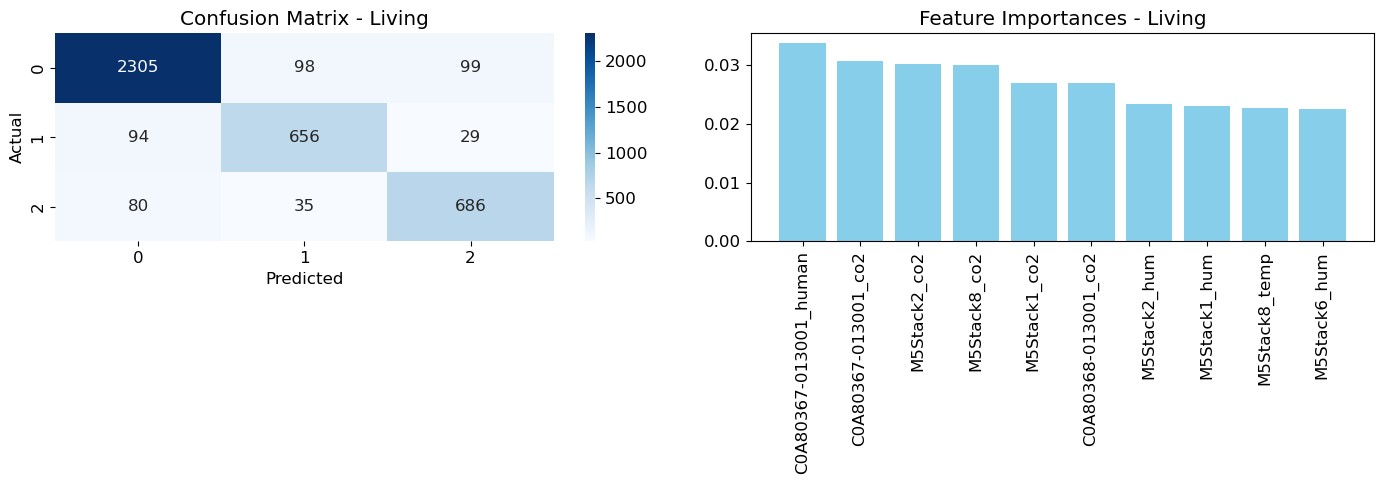


★ Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張を実行中...
[Japanese (Washitu)] 学習データ数: 9524 => 66668 (約7.0倍)
[Japanese (Washitu)] モデル学習中...

★ Japanese (Washitu) 正解率 (Accuracy): 0.9321
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2981
           1       0.86      0.86      0.86       609
           2       0.86      0.87      0.86       492

    accuracy                           0.93      4082
   macro avg       0.89      0.89      0.89      4082
weighted avg       0.93      0.93      0.93      4082



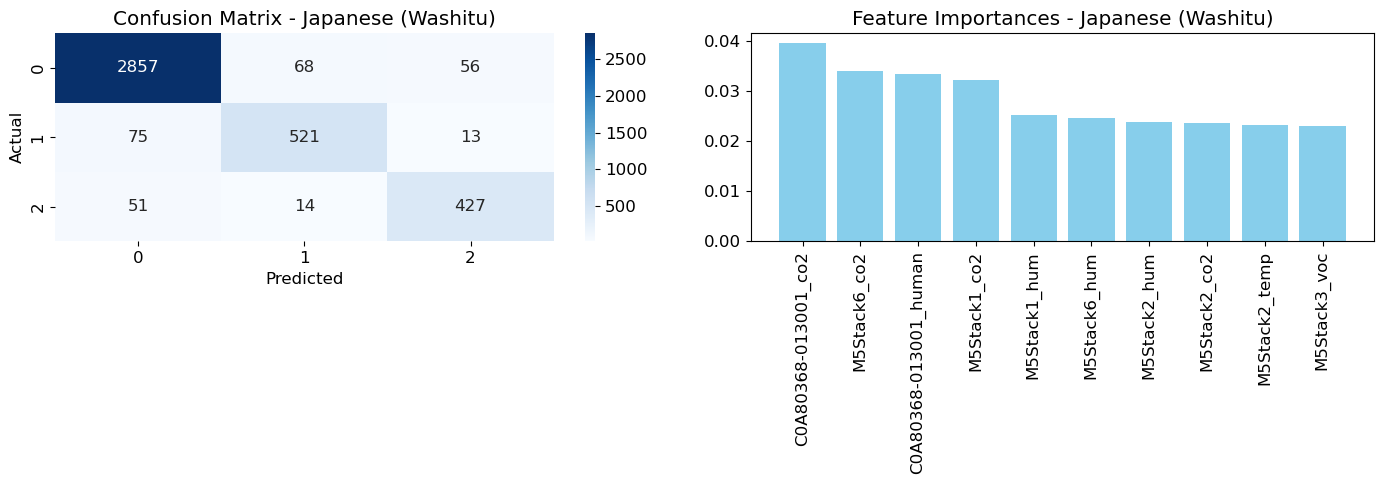


全ての処理が完了しました。


In [7]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 日本語フォント設定（Mac用: AppleGothic, Windows用: Meiryoなど適宜変更）
# plt.rcParams['font.family'] = 'AppleGothic'

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
# ★ここに読み込みたいファイル名をリストで記述してください
file_names = ["smart_home_merged_all.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプがあればソート（時系列順に整列）
if "timestamp" in full_data.columns:
    full_data["timestamp"] = pd.to_datetime(full_data["timestamp"])
    full_data = full_data.sort_values("timestamp").reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
# 欠損値補完（新しい書き方）
full_data = full_data.bfill().ffill().fillna(0)

# 特徴量の自動選択 (全センサーを使用)
# "_co2", "_temp" などが含まれる列と "PIR" が含まれる列を抽出
sensor_cols = [
    c
    for c in full_data.columns
    if any(x in c for x in ["_co2", "_temp", "_hum", "_voc", "_pm2_5"])
]
pir_cols = [c for c in full_data.columns if "PIR" in c]

# ここで数値データ以外（文字列など）が混ざらないようにフィルタリング
numeric_cols_only = full_data.select_dtypes(include=["number", "bool"]).columns
features = [c for c in (sensor_cols + pir_cols) if c in numeric_cols_only]

print(f"使用する特徴量の数: {len(features)}")
# print(features) # 特徴量の中身を見たい場合はコメントアウトを外す


# ==============================================================================
# 3. 強化版データオーグメンテーション関数
# ==============================================================================
def augment_data_enhanced(
    X, y, noise_level=0.05, shift_steps=[-2, -1, 1, 2], scaling_range=(0.95, 1.05)
):
    """
    データ拡張を行う関数（強化版）
    1. ノイズ付加: センサーの微細な揺らぎを再現
    2. タイムシフト: 応答遅れや早まりを再現（範囲拡大）
    3. スケーリング: センサー感度の個体差や環境差を再現
    """
    X_aug_list = [X]
    y_aug_list = [y]

    # 数値カラムのみ抽出（計算エラー防止）
    numeric_cols = X.select_dtypes(include=[np.number]).columns

    # --- 1. ノイズ付加 (Gaussian Noise) ---
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # --- 2. タイムシフト (Time Shift) ---
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    # --- 3. スケーリング (Scaling) ---
    # 値全体をランダムに 0.95倍 ~ 1.05倍 する
    factor = np.random.uniform(scaling_range[0], scaling_range[1])
    X_scaled = X.copy()
    X_scaled[numeric_cols] = X_scaled[numeric_cols] * factor
    X_aug_list.append(X_scaled)
    y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(
        y_aug_list, ignore_index=True
    )


# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    "Living": "Label_Living_Count",  # リビングの正解ラベル
    "Japanese (Washitu)": "Label_Japanese_Count",  # 和室の正解ラベル
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "=" * 60)
    print(f"★ {room_name} の人数推定を開始します (Target: {target_col})")
    print("=" * 60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"[Skip] {target_col} がデータに含まれていません。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features].copy()
    y = df_model[target_col].copy()

    # Boolean -> Int 変換
    for col in X.select_dtypes(include=["bool"]).columns:
        X[col] = X[col].astype(int)

    # データの分割 (Shuffle=True で多様なパターンを学習)
    # ※時系列を厳密に見るなら shuffle=False にしてください
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=True
    )

    # データ拡張の実行
    print(f"[{room_name}] データ拡張を実行中...")
    original_size = len(X_train)

    # 強化版関数を使用
    X_train_aug, y_train_aug = augment_data_enhanced(
        X_train,
        y_train,
        noise_level=0.05,
        shift_steps=[-2, -1, 1, 2],
        scaling_range=(0.95, 1.05),
    )

    print(
        f"[{room_name}] 学習データ数: {original_size} => {len(X_train_aug)} (約{len(X_train_aug)/original_size:.1f}倍)"
    )

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",  # 少数派クラス（2人など）を重視
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")

    # warningが出ないように zero_division=0 を設定
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 1. 混同行列 (Confusion Matrix)
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {room_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # 2. 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10

    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center", color="skyblue")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

print("\n全ての処理が完了しました。")

データを読み込んでいます...
学習曲線を計算中... (データ数: 13606)


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/1386457350.py:42: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


完了: グラフを 'learning_curve.png' に保存しました。


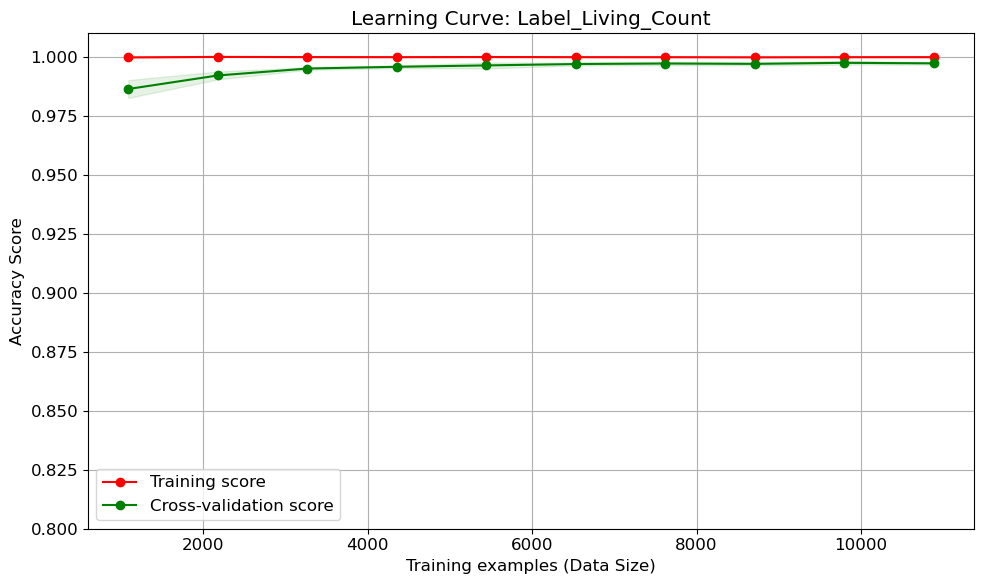

In [8]:
# ==============================================================================
# 学習曲線描画プログラム
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 設定
FILE_PATH = "smart_home_merged_all.csv"  # 分析したいファイル名
TARGET_COL = "Label_Living_Count"  # 予測したい正解ラベル（リビングの人数）


def plot_learning_curve_program():
    print("データを読み込んでいます...")
    try:
        df = pd.read_csv(FILE_PATH, low_memory=False)
    except FileNotFoundError:
        print(f"エラー: {FILE_PATH} が見つかりません。")
        return

    # 前処理: ターゲットがある行だけ残す
    df = df.dropna(subset=[TARGET_COL])
    df[TARGET_COL] = df[TARGET_COL].astype(int)
    # 対象クラスを限定（0,1,2人のみ）
    df = df[df[TARGET_COL].isin([0, 1, 2])]

    # 特徴量と正解ラベルの分離
    # "Label_" がつくカラムは答えなので除外
    label_cols = [c for c in df.columns if "Label_" in c]
    drop_cols = label_cols + ["timestamp"] if "timestamp" in df.columns else label_cols

    X = df.drop(columns=drop_cols, errors="ignore")
    y = df[TARGET_COL]

    # 数値化処理 & 欠損値埋め
    le = LabelEncoder()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="ignore")
        if X[col].dtype == "object":
            X[col] = X[col].astype(str)
            # True/False の変換
            if X[col].iloc[0].lower() in ["true", "false"]:
                X[col] = (
                    X[col].map({"True": 1, "False": 0, "true": 1, "false": 0}).fillna(0)
                )
            else:
                X[col] = le.fit_transform(X[col])

    # 全てNaNの列を削除してから欠損埋め
    X = X.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    print(f"学習曲線を計算中... (データ数: {len(X_imputed)})")

    # --- 学習曲線の計算 ---
    # train_sizes: データの10%〜100%まで10段階で増やす
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=RandomForestClassifier(
            n_estimators=50, random_state=42, max_depth=10
        ),
        X=X_imputed,
        y=y,
        cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),  # 5回交差検証
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
    )

    # 平均と標準偏差を計算
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # --- グラフ描画 ---
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve: {TARGET_COL}")
    plt.xlabel("Training examples (Data Size)")
    plt.ylabel("Accuracy Score")
    plt.ylim(0.8, 1.01)  # Y軸の範囲（0.8〜1.0）
    plt.grid()

    # Training Score (赤)
    plt.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="r",
    )
    plt.plot(train_sizes, train_mean, "o-", color="r", label="Training score")

    # Validation Score (緑)
    plt.fill_between(
        train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g"
    )
    plt.plot(train_sizes, test_mean, "o-", color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()

    # 画像保存
    plt.savefig("learning_curve.png")
    print("完了: グラフを 'learning_curve.png' に保存しました。")
    plt.show()


if __name__ == "__main__":
    plot_learning_curve_program()

データを読み込んでいます...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/3052436743.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


学習開始 (1本 〜 100本)...
学習完了。グラフを作成します...


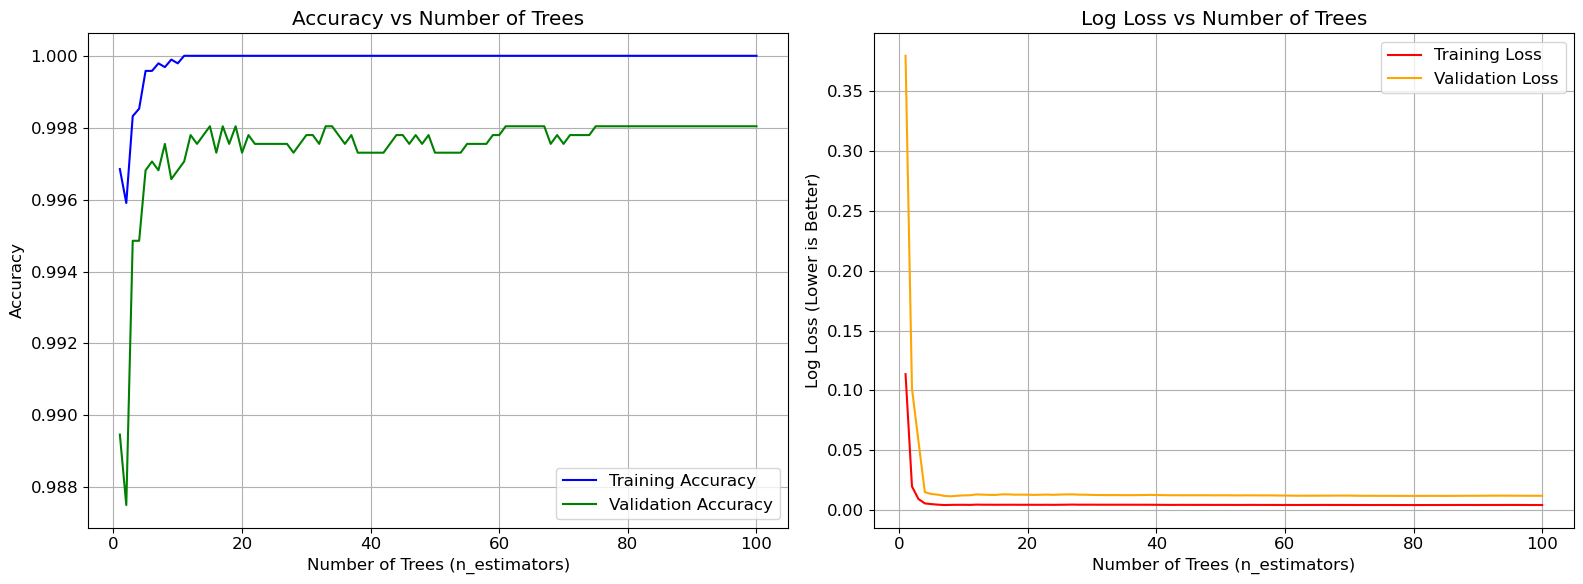

グラフを 'learning_process_graphs.png' に保存しました。


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 設定
# ==========================================
FILE_PATH = "smart_home_merged_all.csv"
TARGET_COL = "Label_Living_Count"


def plot_training_process():
    print("データを読み込んでいます...")
    try:
        df = pd.read_csv(FILE_PATH, low_memory=False)
    except FileNotFoundError:
        print(f"エラー: {FILE_PATH} が見つかりません。")
        return

    # 前処理
    df = df.dropna(subset=[TARGET_COL])
    df[TARGET_COL] = df[TARGET_COL].astype(int)
    df = df[df[TARGET_COL].isin([0, 1, 2])]

    # 特徴量抽出
    label_cols = [c for c in df.columns if "Label_" in c]
    drop_cols = label_cols + ["timestamp"] if "timestamp" in df.columns else label_cols
    X = df.drop(columns=drop_cols, errors="ignore")
    y = df[TARGET_COL]

    # 数値化 & 欠損埋め
    le = LabelEncoder()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="ignore")
        if X[col].dtype == "object":
            X[col] = X[col].astype(str)
            if X[col].iloc[0].lower() in ["true", "false"]:
                X[col] = (
                    X[col].map({"True": 1, "False": 0, "true": 1, "false": 0}).fillna(0)
                )
            else:
                X[col] = le.fit_transform(X[col])

    X = X.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # データ分割
    X_train, X_val, y_train, y_val = train_test_split(
        X_imputed, y, test_size=0.3, random_state=42
    )

    # ==========================================
    # 学習過程の記録 (Iterative Training)
    # ==========================================
    # warm_start=True にすることで、学習済みの状態から木を追加できる
    rf = RandomForestClassifier(
        n_estimators=1, warm_start=True, random_state=42, n_jobs=-1
    )

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    min_trees = 1
    max_trees = 100  # ここを増やすとさらに長い過程が見られます

    print(f"学習開始 (1本 〜 {max_trees}本)...")

    for i in range(min_trees, max_trees + 1):
        rf.n_estimators = i
        rf.fit(X_train, y_train)

        # 予測
        train_pred = rf.predict(X_train)
        val_pred = rf.predict(X_val)

        # 確率予測 (Loss計算用)
        train_proba = rf.predict_proba(X_train)
        val_proba = rf.predict_proba(X_val)

        # 指標計算
        train_acc.append(accuracy_score(y_train, train_pred))
        val_acc.append(accuracy_score(y_val, val_pred))
        train_loss.append(log_loss(y_train, train_proba))
        val_loss.append(log_loss(y_val, val_proba))

    print("学習完了。グラフを作成します...")

    # ==========================================
    # グラフ描画
    # ==========================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Accuracy Graph
    axes[0].plot(
        range(min_trees, max_trees + 1),
        train_acc,
        label="Training Accuracy",
        color="blue",
    )
    axes[0].plot(
        range(min_trees, max_trees + 1),
        val_acc,
        label="Validation Accuracy",
        color="green",
    )
    axes[0].set_title("Accuracy vs Number of Trees")
    axes[0].set_xlabel("Number of Trees (n_estimators)")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # 2. Loss Graph
    axes[1].plot(
        range(min_trees, max_trees + 1), train_loss, label="Training Loss", color="red"
    )
    axes[1].plot(
        range(min_trees, max_trees + 1),
        val_loss,
        label="Validation Loss",
        color="orange",
    )
    axes[1].set_title("Log Loss vs Number of Trees")
    axes[1].set_xlabel("Number of Trees (n_estimators)")
    axes[1].set_ylabel("Log Loss (Lower is Better)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig("learning_process_graphs.png")
    plt.show()
    print("グラフを 'learning_process_graphs.png' に保存しました。")


if __name__ == "__main__":
    plot_training_process()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 設定
# ==========================================
FILE_PATH = "smart_home_merged_all.csv"

# 分析対象リスト
TARGETS = {"Living": "Label_Living_Count", "Japanese": "Label_Japanese_Count"}


def feature_engineering(df):
    """特徴量生成（CO2変化率の追加）"""
    # 変化率計算のために一時的にソート
    df = df.sort_values("timestamp").copy()

    # 時間間隔（分）
    df["dt_min"] = df["timestamp"].diff().dt.total_seconds() / 60.0

    # CO2カラム変化率
    co2_cols = [c for c in df.columns if "co2" in c.lower() and "Label" not in c]
    for col in co2_cols:
        # トレンド（移動平均）の変化率
        smooth_val = df[col].rolling(window=5, min_periods=1).mean()
        df[f"{col}_rate"] = smooth_val.diff() / df["dt_min"]
        df[f"{col}_rate"] = df[f"{col}_rate"].fillna(0)

    df = df.drop(columns=["dt_min"])
    return df


def analyze_room_overall(df_all, room_name, target_col):
    print(f"\n{'='*50}")
    print(f"分析対象: {room_name} (Target: {target_col})")
    print(f"{'='*50}")

    # 1. ターゲットの整理
    # 対象カラムが欠損していない行を使用
    df = df_all.dropna(subset=[target_col]).copy()
    df[target_col] = df[target_col].astype(int)
    # 0, 1, 2人のデータのみに絞る
    df = df[df[target_col].isin([0, 1, 2])]

    # 2. 特徴量生成
    df = feature_engineering(df)

    # 3. 【重要】リークの排除 (Label_系を全て削除)
    # これを行わないと正解率が100%になってしまいます
    label_cols = [c for c in df.columns if "Label_" in c]
    drop_cols = label_cols + ["timestamp"]

    # 特徴量 (X) と 正解 (y) の準備
    X = df.drop(columns=drop_cols, errors="ignore")
    y = df[target_col]

    print(f"削除したラベル系カラム: {len(label_cols)}個")
    # print(f" -> {label_cols}") # 確認したい場合はコメントアウトを外す

    # 4. 数値化 & 欠損埋め
    le = LabelEncoder()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="ignore")
        if X[col].dtype == "object":
            X[col] = X[col].astype(str)
            if X[col].iloc[0].lower() in ["true", "false"]:
                X[col] = (
                    X[col].map({"True": 1, "False": 0, "true": 1, "false": 0}).fillna(0)
                )
            else:
                X[col] = le.fit_transform(X[col])

    X = X.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # 照明の除外（人数推定用）
    illuminance_cols = [c for c in X_imputed.columns if "illu" in c.lower()]
    X_counting = X_imputed.drop(columns=illuminance_cols)
    print(f"人数推定から除外した照明カラム: {illuminance_cols}")

    # =========================================================
    # Task 1: 在不在判定 (Occupancy Detection: 0 vs 1+)
    # =========================================================
    print(f"\n--- [{room_name}] Task 1: 在不在判定 (0 vs 1以上) ---")
    y_occupancy = (y > 0).astype(int)

    # 全体をランダムに分割 (Shuffle=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y_occupancy, test_size=0.3, random_state=42, shuffle=True
    )

    clf_occ = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_occ.fit(X_train, y_train)

    acc = accuracy_score(y_test, clf_occ.predict(X_test))
    print(f"正解率: {acc:.4f}")
    print(confusion_matrix(y_test, clf_occ.predict(X_test)))

    # 重要度 (Task 1)
    imp_occ = pd.Series(
        clf_occ.feature_importances_, index=X_imputed.columns
    ).sort_values(ascending=False)
    print("Top 5 Features (在不在):")
    print(imp_occ.head(5))

    # =========================================================
    # Task 2: 人数推定 (People Counting: 1 vs 2)
    # =========================================================
    print(f"\n--- [{room_name}] Task 2: 人数推定 (在室時のみ: 1 vs 2) ---")

    # 在室時のみ (y > 0) のデータを使用
    mask_present = y > 0
    if mask_present.sum() < 20:
        print("データ不足のためスキップ")
        return

    X_target = X_counting[mask_present]  # 照明なしデータ
    y_target = y[mask_present]

    if len(y_target.unique()) < 2:
        print("クラスが1種類しかないためスキップ")
        return

    # 全体をランダムに分割 (Shuffle=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X_target, y_target, test_size=0.3, random_state=42, shuffle=True
    )

    clf_count = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_count.fit(X_train, y_train)

    y_pred = clf_count.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"正解率: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # 重要度 (Task 2)
    imp_count = pd.Series(
        clf_count.feature_importances_, index=X_counting.columns
    ).sort_values(ascending=False)

    print(f"Top 10 Features ({room_name} 人数推定):")
    print(imp_count.head(10))

    # CO2変化率の順位確認
    rate_cols = [c for c in imp_count.index if "rate" in c]
    print(f"\nCO2変化率カラムの順位 ({room_name}):")
    for c in rate_cols:
        rank = imp_count.index.get_loc(c) + 1
        print(f" - {c}: {rank}位 (Score: {imp_count[c]:.4f})")

    # グラフ化と保存
    plt.figure(figsize=(12, 6))
    sns.barplot(x=imp_count.head(15), y=imp_count.head(15).index, palette="viridis")
    plt.title(f"Feature Importance: {room_name} Counting (1 vs 2) - No Illuminance")
    plt.xlabel("Importance")
    plt.tight_layout()

    filename = f"importance_overall_{room_name}.png"
    plt.savefig(filename)
    print(f"グラフを保存しました: {filename}")
    plt.close()


def main():
    print("=== 全体データ分析プログラム開始 ===")
    try:
        df_all = pd.read_csv(FILE_PATH, low_memory=False)
    except FileNotFoundError:
        print(f"ファイル {FILE_PATH} が見つかりません。")
        return

    if "timestamp" in df_all.columns:
        df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])

    for room, target in TARGETS.items():
        if target in df_all.columns:
            analyze_room_overall(df_all, room, target)
        else:
            print(f"警告: {target} が見つかりません。")


if __name__ == "__main__":
    main()

=== 全体データ分析プログラム開始 ===

分析対象: Living (Target: Label_Living_Count)
削除したラベル系カラム: 25個


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/619567114.py:70: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


人数推定から除外した照明カラム: ['C0A8033B-013501_illuminance', 'C0A8033E-013501_illuminance', 'C0A80341-013501_illuminance', 'C0A8033D-013501_illuminance', 'C0A8033C-013501_illuminance', 'C0A80342-013501_illuminance', 'C0A80343-013501_illuminance', 'C0A80344-013501_illuminance']

--- [Living] Task 1: 在不在判定 (0 vs 1以上) ---
正解率: 0.9978
[[2497    5]
 [   4 1576]]
Top 5 Features (在不在):
C0A8033B-013501_illuminance    0.135276
C0A80367-013001_co2            0.046056
C0A80367-013001_human          0.046040
M5Stack2_co2_rate              0.045654
M5Stack8_co2                   0.044848
dtype: float64

--- [Living] Task 2: 人数推定 (在室時のみ: 1 vs 2) ---
正解率: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       796
           2       1.00      1.00      1.00       794

    accuracy                           1.00      1590
   macro avg       1.00      1.00      1.00      1590
weighted avg       1.00      1.00      1.00      1590

Top 10 Features (Living 人数推定)

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/619567114.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_count.head(15), y=imp_count.head(15).index, palette="viridis")
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/619567114.py:70: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X[col] = pd.to_numeric(X[col], errors="ignore")


人数推定から除外した照明カラム: ['C0A8033B-013501_illuminance', 'C0A8033E-013501_illuminance', 'C0A80341-013501_illuminance', 'C0A8033D-013501_illuminance', 'C0A8033C-013501_illuminance', 'C0A80342-013501_illuminance', 'C0A80343-013501_illuminance', 'C0A80344-013501_illuminance']

--- [Japanese] Task 1: 在不在判定 (0 vs 1以上) ---
正解率: 0.9988
[[2980    1]
 [   4 1097]]
Top 5 Features (在不在):
C0A80341-013501_illuminance    0.084131
M5Stack1_co2                   0.062219
M5Stack1_co2_rate              0.056767
C0A80368-013001_human          0.051186
C0A80368-013001_co2_rate       0.041532
dtype: float64

--- [Japanese] Task 2: 人数推定 (在室時のみ: 1 vs 2) ---
正解率: 0.9973
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       642
           2       1.00      1.00      1.00       490

    accuracy                           1.00      1132
   macro avg       1.00      1.00      1.00      1132
weighted avg       1.00      1.00      1.00      1132

Top 10 Features (Japanese

/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_5852/619567114.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_count.head(15), y=imp_count.head(15).index, palette="viridis")


In [ ]:
import pandas as pd
import numpy as np

# ==========================================
# 設定
# ==========================================
INPUT_FILE = "smart_home_merged_all.csv"
OUTPUT_FILE = "smart_home_features_added.csv"


def add_features():
    print("データを読み込んでいます...")
    try:
        df = pd.read_csv(INPUT_FILE, low_memory=False)
    except FileNotFoundError:
        print(f"エラー: {INPUT_FILE} が見つかりません。")
        return

    # 1. タイムスタンプの整理
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.sort_values("timestamp").reset_index(drop=True)
    else:
        print("エラー: timestampカラムがありません。時系列データとして処理できません。")
        return

    print(f"元のデータサイズ: {df.shape}")

    # 2. 時間間隔（分）の計算
    # 前の行との時間差を計算します（分単位）
    df["dt_min"] = df["timestamp"].diff().dt.total_seconds() / 60.0

    # 最初の行や、間隔が0になってしまう行の処理（無限大の発散防止）
    df["dt_min"] = df["dt_min"].replace(0, np.nan)

    # ==========================================
    # 特徴量生成: CO2, VOC などの「変化率」
    # ==========================================
    # 対象とするセンサーのカラム名（CO2, VOC, 温度, 湿度）
    # ここに含まれる文字列を持つカラム全てに対して変化率を計算します
    target_keywords = ["co2", "voc", "temp", "hum"]

    # 除外するキーワード（正解ラベルや設定値などは計算しない）
    exclude_keywords = ["Label", "set", "Rate", "dt_min"]

    target_cols = []
    for col in df.columns:
        # キーワードを含み、かつ除外ワードを含まない数値カラム
        if (
            any(k in col.lower() for k in target_keywords)
            and not any(ex in col for ex in exclude_keywords)
            and pd.api.types.is_numeric_dtype(df[col])
        ):
            target_cols.append(col)

    print(f"\n変化率を計算するカラム数: {len(target_cols)}")

    count_added = 0
    for col in target_cols:
        # A. 瞬時変化率 (Instant Rate)
        # (今回の値 - 前回の値) / 経過時間(分)
        # 意味: 「今、この瞬間の勢い」
        col_rate_name = f"{col}_rate"
        df[col_rate_name] = df[col].diff() / df["dt_min"]

        # B. トレンド変化率 (Smoothed Trend Rate) ★人数推定に特に有効
        # 5分間の移動平均をとってから、その変化率を見る
        # 意味: 「ノイズを除去した、大きな増減の傾向」
        # 入室直後の緩やかな上昇などを捉えるのに適しています
        col_smooth_name = f"{col}_rate_smooth"
        smooth_val = df[col].rolling(window=5, min_periods=1).mean()
        df[col_smooth_name] = smooth_val.diff() / df["dt_min"]

        # 最初の行などはNaNになるので0で埋める
        df[col_rate_name] = df[col_rate_name].fillna(0)
        df[col_smooth_name] = df[col_smooth_name].fillna(0)

        count_added += 2

    # 計算に使った一時カラムを削除
    df = df.drop(columns=["dt_min"])

    # ==========================================
    # 保存
    # ==========================================
    print(f"\n特徴量追加完了: {count_added} 個の新しいカラムを作成しました。")
    print(f"保存中... -> {OUTPUT_FILE}")

    df.to_csv(OUTPUT_FILE, index=False)
    print("完了しました。")

    # 確認用: 新しいカラムの一部を表示
    new_cols = [c for c in df.columns if "_rate" in c]
    if new_cols:
        print("\n--- 作成されたカラムの例 (最初の5行) ---")
        print(df[["timestamp"] + new_cols[:2]].head())


if __name__ == "__main__":
    add_features()